In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
from utilityFunctions import *

from style_encoder import StyleEncoder
from content_encoder import ContentEncoder
from discriminator import Discriminator
from new_decoder import Decoder, compute_comprehensive_loss
from losses import (infoNCE_loss, margin_loss, adversarial_loss, 
                   disentanglement_loss)
from dataloader import get_dataloader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")


Using device: cuda
GPU: NVIDIA GeForce RTX 3080


In [ ]:
# train parameters
config = {
    "style_dim": 256,
    "content_dim": 256,
    "transformer_heads": 4,
    "transformer_layers": 4,
    "cnn_channels": [16, 32, 64, 128, 256],
    
    # Training params
    "epochs": 100,
    "batch_size": 16,          
    "lr_gen": 3e-5,
    "lr_disc": 1e-5,
    "beta1": 0.5,
    "beta2": 0.999,
    "weight_decay": 1e-4, 
    
    # losses weights
    "lambda_adv_disc": 0.5,
    "lambda_adv_gen": 0.3,
    "lambda_disent": 0.8,
    "lambda_cont": 0.1,
    "lambda_margin": 0.05,
    "lambda_recon": 5.0,
    
    # for stability
    "grad_clip_value": 0.5, 
    "warmup_epochs": 5,
    "nan_threshold": 5,          # Max NaN consecutivi
    
    # paths
    "piano_dir": "dataset/train/piano",
    "violin_dir": "dataset/train/violin",
    "stats_path": "stats_stft_cqt.npz",
    
    # save
    "save_dir": "checkpoints",
    "save_interval": 10,
    
    # training strategy ----> EXPERIMENT WITH DIFFERENT VALUES
    "discriminator_steps": 1,
    "generator_steps": 2,
}

os.makedirs(config["save_dir"], exist_ok=True)

In [ ]:
# conservative weight initialization
def init_weights_conservative(m):
    """
    Inizializzazione conservativa dei pesi per prevenire NaN
    """
    if isinstance(m, nn.Conv2d):
        # Xavier uniforme con gain ridotto
        nn.init.xavier_uniform_(m.weight, gain=0.2)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        # Xavier uniforme con gain ridotto
        nn.init.xavier_uniform_(m.weight, gain=0.2)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

# utility functions

def check_for_nan(*tensors, names=None):
    """
    Controlla se ci sono NaN o Inf nei tensori
    
    Args:
        *tensors: Tensori da controllare
        names: Nomi dei tensori per il debug
    
    Returns:
        bool: True se trovati NaN/Inf
    """
    if names is None:
        names = [f"tensor_{i}" for i in range(len(tensors))]
    
    for tensor, name in zip(tensors, names):
        if torch.isnan(tensor).any():
            print(f"🚨 NaN detected in {name}")
            return True
        if torch.isinf(tensor).any():
            print(f"🚨 Inf detected in {name}")
            return True
    return False



def set_requires_grad(models, requires_grad):
    """
    Abilita/disabilita i gradienti per i modelli
    
    Args:
        models: Modello singolo o lista di modelli
        requires_grad: True per abilitare, False per disabilitare
    """
    if not isinstance(models, list):
        models = [models]
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad



def get_learning_rate_multiplier(epoch, warmup_epochs):
    """
    Calcola il moltiplicatore del learning rate per il warmup
    
    Args:
        epoch: Epoca corrente
        warmup_epochs: Numero di epoche di warmup
    
    Returns:
        float: Moltiplicatore del learning rate
    """
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    return 1.0

def save_checkpoint(epoch, models_dict, optimizers_dict, schedulers_dict, config):
    """
    Salva checkpoint completo
    
    Args:
        epoch: Epoca corrente
        models_dict: Dizionario dei modelli
        optimizers_dict: Dizionario degli ottimizzatori
        schedulers_dict: Dizionario degli schedulers
        config: Configurazione
    """
    checkpoint = {
        'epoch': epoch,
        'config': config
    }
    
    # Salva stati dei modelli
    for name, model in models_dict.items():
        checkpoint[name] = model.state_dict()
    
    # Salva stati degli ottimizzatori
    for name, optimizer in optimizers_dict.items():
        checkpoint[name] = optimizer.state_dict()
    
    # Salva stati degli schedulers
    for name, scheduler in schedulers_dict.items():
        checkpoint[name] = scheduler.state_dict()
    
    checkpoint_path = os.path.join(config["save_dir"], f"checkpoint_epoch_{epoch}.pth")
    torch.save(checkpoint, checkpoint_path)
    print(f"💾 Checkpoint saved: {checkpoint_path}")

In [12]:
# model initialization
print("Initializing models...")

style_encoder = StyleEncoder(
    cnn_out_dim=config["style_dim"],
    transformer_dim=config["style_dim"],
    num_heads=config["transformer_heads"],
    num_layers=config["transformer_layers"]
).to(device)

content_encoder = ContentEncoder(
    cnn_out_dim=config["content_dim"],
    transformer_dim=config["content_dim"],
    num_heads=config["transformer_heads"],
    num_layers=config["transformer_layers"],
    channels_list=config["cnn_channels"]
).to(device)

discriminator = Discriminator(
    input_dim=config["style_dim"],
    hidden_dim=128
).to(device)

decoder = Decoder(
    d_model=config["style_dim"],
    nhead=config["transformer_heads"],
    num_layers=config["transformer_layers"]
).to(device)

# Applica inizializzazione conservativa
models = [style_encoder, content_encoder, discriminator, decoder]
model_names = ["style_encoder", "content_encoder", "discriminator", "decoder"]

for model, name in zip(models, model_names):
    model.apply(init_weights_conservative)
    print(f"{name} initialized")


# ottimizzazione regolare
# from style_encoder import initialize_weights
# initialize_weights(style_encoder)
# initialize_weights(content_encoder)
# initialize_weights(decoder)
# initialize_weights(discriminator)

Initializing models...
style_encoder initialized
content_encoder initialized
discriminator initialized
decoder initialized


In [ ]:
# optimizers and schedulers
print("🔧 Setting up optimizers and schedulers...")

optimizer_G = optim.AdamW(
    list(style_encoder.parameters()) + 
    list(content_encoder.parameters()) + 
    list(decoder.parameters()),
    lr=config["lr_gen"],
    betas=(config["beta1"], config["beta2"]),
    weight_decay=config["weight_decay"]
)

optimizer_D = optim.AdamW(
    discriminator.parameters(),
    lr=config["lr_disc"],
    betas=(config["beta1"], config["beta2"]),
    weight_decay=config["weight_decay"]
)

# Schedulers
scheduler_G = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_G, mode='min', factor=0.7, patience=5
)

scheduler_D = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_D, mode='min', factor=0.7, patience=5
)

# dataloader
print("🔧 Setting up dataloader...")

try:
    train_loader = get_dataloader(
        piano_dir=config["piano_dir"],
        violin_dir=config["violin_dir"],
        batch_size=config["batch_size"],
        shuffle=True,
        stats_path=config["stats_path"]
    )
    print(f"✅ DataLoader created successfully with batch_size={config['batch_size']}")
except Exception as e:
    print(f"❌ Error creating DataLoader: {e}")
    raise

🔧 Setting up optimizers and schedulers...
🔧 Setting up dataloader...
✅ Loaded separate statistics:
  Piano: train_set_stats/stats_stft_cqt_piano.npz
  Violin: train_set_stats/stats_stft_cqt_violin.npz
✅ DataLoader created successfully with batch_size=16


In [ ]:
# training steps for discriminator and generator
def discriminator_training_step(x, labels, epoch):

    # only discriminator requires gradients
    set_requires_grad(discriminator, True)
    set_requires_grad([style_encoder, content_encoder, decoder], False)
    
    try:
        # no gradient flow for generators
        with torch.no_grad():
            style_emb, class_emb = style_encoder(x, labels)
            content_emb = content_encoder(x)
        
        # NaN check
        if check_for_nan(style_emb, class_emb, content_emb, 
                         names=["style_emb", "class_emb", "content_emb"]):
            return float('nan')
        
        # detach embeddings to avoid gradient flow
        disc_loss, _ = adversarial_loss(
            style_emb.detach(),
            class_emb.detach(),
            content_emb.detach(),
            discriminator,
            labels,
            compute_for_discriminator=True,
            lambda_content=config["lambda_adv_disc"]
        )
        
        # NaN
        if check_for_nan(disc_loss, names=["disc_loss"]):
            return float('nan')
        
        # Backpropagation
        optimizer_D.zero_grad()
        disc_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), config["grad_clip_value"])
        
        # Controllo gradienti per NaN
        for name, param in discriminator.named_parameters():
            if param.grad is not None:
                if check_for_nan(param.grad, names=[f"discriminator.{name}.grad"]):
                    return float('nan')
        
        optimizer_D.step()
        return disc_loss.item()
        
    except Exception as e:
        print(f"❌ Error in discriminator training step: {e}")
        return float('nan')



def generator_training_step(x, labels, epoch):

    set_requires_grad([style_encoder, content_encoder, decoder], True)
    set_requires_grad(discriminator, False)
    
    try:

        style_emb, class_emb = style_encoder(x, labels)
        content_emb = content_encoder(x)
        

        if check_for_nan(style_emb, class_emb, content_emb,
                         names=["style_emb", "class_emb", "content_emb"]):
            return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}
        

        _, adv_gen_loss = adversarial_loss(
            style_emb,
            class_emb,
            content_emb,
            discriminator,
            labels,
            compute_for_discriminator=False,
            lambda_content=config["lambda_adv_gen"]
        )
        
        # disentanglement
        disent_loss = disentanglement_loss(
            style_emb,
            content_emb.mean(dim=1),
            use_hsic=True
        )
        
        # contrastive losses
        cont_loss = infoNCE_loss(style_emb, labels)
        
        margin_loss_val = margin_loss(class_emb)
        
        # reconstruction loss
        stft_part = x[:, :, :, :, :513]
        recon_x = decoder(content_emb, style_emb, y=stft_part)
        recon_losses = compute_comprehensive_loss(recon_x, stft_part)
        recon_loss = recon_losses['total_loss']
        
        # NaN
        losses = [adv_gen_loss, disent_loss, cont_loss, margin_loss_val, recon_loss]
        loss_names = ['adv_gen_loss', 'disent_loss', 'cont_loss', 'margin_loss', 'recon_loss']
        
        if check_for_nan(*losses, names=loss_names):
            return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}
        
        # total loss with warmup
        lr_multiplier = get_learning_rate_multiplier(epoch, config["warmup_epochs"])
        warmup_factor = lr_multiplier if epoch < config["warmup_epochs"] else 1.0
        
        total_G_loss = (
            config["lambda_adv_gen"] * adv_gen_loss * warmup_factor +
            config["lambda_disent"] * disent_loss * warmup_factor +
            config["lambda_cont"] * cont_loss * warmup_factor +
            config["lambda_margin"] * margin_loss_val * warmup_factor +
            config["lambda_recon"] * recon_loss
        )
        
        if check_for_nan(total_G_loss, names=["total_G_loss"]):
            return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}
        
        # Backpropagation
        optimizer_G.zero_grad()
        total_G_loss.backward()
        
        # Gradient clipping
        generator_params = (
            list(style_encoder.parameters()) + 
            list(content_encoder.parameters()) +
            list(decoder.parameters())
        )
        torch.nn.utils.clip_grad_norm_(generator_params, config["grad_clip_value"])
        
        # NaN
        for model, model_name in [(style_encoder, "style_encoder"), 
                                 (content_encoder, "content_encoder"), 
                                 (decoder, "decoder")]:
            for name, param in model.named_parameters():
                if param.grad is not None:
                    if check_for_nan(param.grad, names=[f"{model_name}.{name}.grad"]):
                        return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}
        
        optimizer_G.step()
        
        return {
            'total_G': total_G_loss.item(),
            'adv_gen': adv_gen_loss.item(),
            'disent': disent_loss.item(),
            'cont': cont_loss.item(),
            'margin': margin_loss_val.item(),
            'recon': recon_loss.item()
        }
        
    except Exception as e:
        print(f"❌ Error in generator training step: {e}")
        return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}

🚀 Starting training with enhanced NaN protection...
📊 Configuration: {'style_dim': 256, 'content_dim': 256, 'transformer_heads': 4, 'transformer_layers': 4, 'cnn_channels': [16, 32, 64, 128, 256], 'epochs': 100, 'batch_size': 16, 'lr_gen': 3e-05, 'lr_disc': 1e-05, 'beta1': 0.5, 'beta2': 0.999, 'weight_decay': 0.0001, 'lambda_adv_disc': 0.5, 'lambda_adv_gen': 0.3, 'lambda_disent': 0.8, 'lambda_cont': 0.1, 'lambda_margin': 0.05, 'lambda_recon': 5.0, 'grad_clip_value': 0.5, 'warmup_epochs': 5, 'nan_threshold': 5, 'piano_dir': 'dataset/train/piano', 'violin_dir': 'dataset/train/violin', 'stats_path': 'stats_stft_cqt.npz', 'save_dir': 'checkpoints', 'save_interval': 10, 'discriminator_steps': 1, 'generator_steps': 2}


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]


🔄 Epoch 1/100
------------------------------------------------------------


c:\Users\Francesco\anaconda3\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)



📊 Batch 1:
   Discriminator Loss: 1.386349
   Generator Total Loss: 15.388690
     Adv Gen: -0.693146
     Disent: 0.002854
     Cont: 2.705039
     Margin: 0.054525
     Recon: 3.075035
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.380597
   Generator Total Loss: 18.543676
     Adv Gen: -0.693147
     Disent: 0.000049
     Cont: 1.972282
     Margin: 0.000000
     Recon: 3.709162
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:   1%|          | 1/100 [02:23<3:56:00, 143.04s/it]


✅ Epoch 1 Summary:
----------------------------------------
   Disc: 1.383228
   Total G: 18.280889
   Adv Gen: -0.693147
   Disent: 0.000179
   Cont: 2.281578
   Margin: 0.001432
   Recon: 3.655361
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 2/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.380836
   Generator Total Loss: 16.821405
     Adv Gen: -0.693147
     Disent: 0.000044
     Cont: 2.317998
     Margin: 0.000000
     Recon: 3.362370
   Consecutive NaN count: 0
   GPU Memory: 424.5 MB

📊 Batch 26:
   Discriminator Loss: 1.368538
   Generator Total Loss: 11.866914
     Adv Gen: -0.693147
     Disent: 0.000058
     Cont: 2.720109
     Margin: 0.000000
     Recon: 2.368254
   Consecutive NaN count: 0
   GPU Memory: 425.1 MB


Training Progress:   2%|▏         | 2/100 [04:33<3:41:52, 135.84s/it]


✅ Epoch 2 Summary:
----------------------------------------
   Disc: 1.371519
   Total G: 16.263591
   Adv Gen: -0.693147
   Disent: 0.000056
   Cont: 2.105504
   Margin: 0.000000
   Recon: 3.252506
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 3/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.360608
   Generator Total Loss: 11.725679
     Adv Gen: -0.693147
     Disent: 0.000058
     Cont: 1.957102
     Margin: 0.000000
     Recon: 2.346599
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.344879
   Generator Total Loss: 12.704657
     Adv Gen: -0.693147
     Disent: 0.000047
     Cont: 1.953961
     Margin: 0.000000
     Recon: 2.542433
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:   3%|▎         | 3/100 [06:38<3:31:35, 130.88s/it]


✅ Epoch 3 Summary:
----------------------------------------
   Disc: 1.373212
   Total G: 16.091479
   Adv Gen: -0.693147
   Disent: 0.000064
   Cont: 2.138915
   Margin: 0.000000
   Recon: 3.217576
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 4/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.421752
   Generator Total Loss: 12.158838
     Adv Gen: -0.693147
     Disent: 0.000059
     Cont: 1.965222
     Margin: 0.000000
     Recon: 2.433588
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.408286
   Generator Total Loss: 10.935494
     Adv Gen: -0.693147
     Disent: 0.000039
     Cont: 1.957564
     Margin: 0.000000
     Recon: 2.189044
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:   4%|▍         | 4/100 [08:34<3:20:06, 125.06s/it]


✅ Epoch 4 Summary:
----------------------------------------
   Disc: 1.409171
   Total G: 17.515144
   Adv Gen: -0.693147
   Disent: 0.000047
   Cont: 2.030000
   Margin: 0.000000
   Recon: 3.503814
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 5/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.397571
   Generator Total Loss: 12.197311
     Adv Gen: -0.693147
     Disent: 0.000037
     Cont: 1.958681
     Margin: 0.000000
     Recon: 2.441872
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.379148
   Generator Total Loss: 12.150969
     Adv Gen: -0.693147
     Disent: 0.000035
     Cont: 1.950521
     Margin: 0.000000
     Recon: 2.432767
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:   5%|▌         | 5/100 [10:31<3:12:59, 121.89s/it]


✅ Epoch 5 Summary:
----------------------------------------
   Disc: 1.382945
   Total G: 18.215813
   Adv Gen: -0.693147
   Disent: 0.000038
   Cont: 1.956224
   Margin: 0.000000
   Recon: 3.645621
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 6/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.366595
   Generator Total Loss: 15.178515
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.948594
     Margin: 0.000000
     Recon: 3.038315
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.343022
   Generator Total Loss: 11.756292
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.948456
     Margin: 0.000000
     Recon: 2.353874
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:   6%|▌         | 6/100 [12:27<3:07:47, 119.87s/it]


✅ Epoch 6 Summary:
----------------------------------------
   Disc: 1.349320
   Total G: 15.516645
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.933489
   Margin: 0.000000
   Recon: 3.106243
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 7/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.330832
   Generator Total Loss: 12.435064
     Adv Gen: -0.693147
     Disent: 0.000034
     Cont: 1.955125
     Margin: 0.000000
     Recon: 2.489494
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.306440
   Generator Total Loss: 14.187418
     Adv Gen: -0.693147
     Disent: 0.000037
     Cont: 1.948424
     Margin: 0.000000
     Recon: 2.840098
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:   7%|▋         | 7/100 [14:23<3:03:48, 118.58s/it]


✅ Epoch 7 Summary:
----------------------------------------
   Disc: 1.312545
   Total G: 18.034762
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.930102
   Margin: 0.000000
   Recon: 3.609934
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 8/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.302785
   Generator Total Loss: 13.068730
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 2.059364
     Margin: 0.000000
     Recon: 2.614143
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.269098
   Generator Total Loss: 11.669032
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.949761
     Margin: 0.000000
     Recon: 2.336395
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:   8%|▊         | 8/100 [16:19<3:00:45, 117.88s/it]


✅ Epoch 8 Summary:
----------------------------------------
   Disc: 1.276594
   Total G: 13.891040
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.933204
   Margin: 0.000000
   Recon: 2.781128
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 9/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.253969
   Generator Total Loss: 14.429674
     Adv Gen: -0.693147
     Disent: 0.000033
     Cont: 1.948220
     Margin: 0.000000
     Recon: 2.888554
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.230932
   Generator Total Loss: 23.975729
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.956101
     Margin: 0.000000
     Recon: 4.797608
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:   9%|▉         | 9/100 [18:16<2:58:08, 117.46s/it]


✅ Epoch 9 Summary:
----------------------------------------
   Disc: 1.235030
   Total G: 17.946696
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.928962
   Margin: 0.000000
   Recon: 3.592344
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 10/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.213264
   Generator Total Loss: 16.235907
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.948687
     Margin: 0.000000
     Recon: 3.249792
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.184680
   Generator Total Loss: 15.265226
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.949452
     Margin: 0.000000
     Recon: 3.055640
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  10%|█         | 10/100 [20:12<2:55:36, 117.07s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_10.pth

✅ Epoch 10 Summary:
----------------------------------------
   Disc: 1.192371
   Total G: 16.610634
   Adv Gen: -0.693147
   Disent: 0.000030
   Cont: 1.926969
   Margin: 0.000000
   Recon: 3.325172
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 11/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.170290
   Generator Total Loss: 12.987661
     Adv Gen: -0.693146
     Disent: 0.000024
     Cont: 1.949608
     Margin: 0.000000
     Recon: 2.600125
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.138158
   Generator Total Loss: 13.789934
     Adv Gen: -0.693146
     Disent: 0.000029
     Cont: 1.952646
     Margin: 0.000000
     Recon: 2.760518
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  11%|█         | 11/100 [22:08<2:53:26, 116.93s/it]


✅ Epoch 11 Summary:
----------------------------------------
   Disc: 1.146207
   Total G: 15.792449
   Adv Gen: -0.693147
   Disent: 0.000029
   Cont: 1.925817
   Margin: 0.000000
   Recon: 3.161558
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 12/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.120583
   Generator Total Loss: 16.724670
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.948025
     Margin: 0.000000
     Recon: 3.347557
   Consecutive NaN count: 0
   GPU Memory: 424.6 MB

📊 Batch 26:
   Discriminator Loss: 1.088722
   Generator Total Loss: 14.572062
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.948766
     Margin: 0.000000
     Recon: 2.917022
   Consecutive NaN count: 0
   GPU Memory: 425.1 MB


Training Progress:  12%|█▏        | 12/100 [25:19<3:24:36, 139.50s/it]


✅ Epoch 12 Summary:
----------------------------------------
   Disc: 1.100910
   Total G: 16.319415
   Adv Gen: -0.693147
   Disent: 0.000029
   Cont: 1.941246
   Margin: 0.000000
   Recon: 3.266642
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 13/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.070817
   Generator Total Loss: 9.457353
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.948502
     Margin: 0.000000
     Recon: 1.894085
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 1.040291
   Generator Total Loss: 13.772737
     Adv Gen: -0.693146
     Disent: 0.000026
     Cont: 1.951486
     Margin: 0.000000
     Recon: 2.757102
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  13%|█▎        | 13/100 [28:41<3:49:41, 158.41s/it]


✅ Epoch 13 Summary:
----------------------------------------
   Disc: 1.048344
   Total G: 17.853515
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.931206
   Margin: 0.000000
   Recon: 3.573663
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 14/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 1.016775
   Generator Total Loss: 14.984545
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.947958
     Margin: 0.000000
     Recon: 2.999534
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.985164
   Generator Total Loss: 13.641283
     Adv Gen: -0.693146
     Disent: 0.000028
     Cont: 1.953206
     Margin: 0.000000
     Recon: 2.730777
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  14%|█▍        | 14/100 [32:02<4:05:13, 171.09s/it]


✅ Epoch 14 Summary:
----------------------------------------
   Disc: 0.995175
   Total G: 13.695877
   Adv Gen: -0.693146
   Disent: 0.000028
   Cont: 1.927026
   Margin: 0.000000
   Recon: 2.742219
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 15/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.968354
   Generator Total Loss: 12.127221
     Adv Gen: -0.693145
     Disent: 0.000024
     Cont: 1.953774
     Margin: 0.000000
     Recon: 2.427954
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.935939
   Generator Total Loss: 15.257789
     Adv Gen: -0.693146
     Disent: 0.000024
     Cont: 1.957716
     Margin: 0.000000
     Recon: 3.053988
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  15%|█▌        | 15/100 [35:30<4:18:24, 182.41s/it]


✅ Epoch 15 Summary:
----------------------------------------
   Disc: 0.941259
   Total G: 16.826180
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.923565
   Margin: 0.000000
   Recon: 3.368349
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 16/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.914625
   Generator Total Loss: 13.102141
     Adv Gen: -0.693146
     Disent: 0.000029
     Cont: 1.968254
     Margin: 0.000000
     Recon: 2.622647
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.880356
   Generator Total Loss: 18.475268
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.953442
     Margin: 0.000000
     Recon: 3.697569
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  16%|█▌        | 16/100 [39:10<4:31:07, 193.66s/it]


✅ Epoch 16 Summary:
----------------------------------------
   Disc: 0.888788
   Total G: 17.535253
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.927702
   Margin: 0.000000
   Recon: 3.510081
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 17/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.861065
   Generator Total Loss: 14.848908
     Adv Gen: -0.693146
     Disent: 0.000024
     Cont: 1.956327
     Margin: 0.000000
     Recon: 2.972240
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.835216
   Generator Total Loss: 19.007369
     Adv Gen: -0.693146
     Disent: 0.000026
     Cont: 1.958084
     Margin: 0.000000
     Recon: 3.803897
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  17%|█▋        | 17/100 [43:02<4:43:44, 205.11s/it]


✅ Epoch 17 Summary:
----------------------------------------
   Disc: 0.836829
   Total G: 15.578159
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.927847
   Margin: 0.000000
   Recon: 3.118659
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 18/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.808006
   Generator Total Loss: 14.811633
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.947857
     Margin: 0.000000
     Recon: 2.964954
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.775574
   Generator Total Loss: 11.026810
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.948301
     Margin: 0.000000
     Recon: 2.207980
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  18%|█▊        | 18/100 [46:54<4:51:31, 213.31s/it]


✅ Epoch 18 Summary:
----------------------------------------
   Disc: 0.785998
   Total G: 17.822753
   Adv Gen: -0.693146
   Disent: 0.000028
   Cont: 1.926199
   Margin: 0.000000
   Recon: 3.567611
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 19/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.757200
   Generator Total Loss: 18.564939
     Adv Gen: -0.693145
     Disent: 0.000029
     Cont: 1.951944
     Margin: 0.000000
     Recon: 3.715533
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.732508
   Generator Total Loss: 16.721406
     Adv Gen: -0.693146
     Disent: 0.000029
     Cont: 1.966067
     Margin: 0.000000
     Recon: 3.346544
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  19%|█▉        | 19/100 [50:42<4:53:36, 217.48s/it]


✅ Epoch 19 Summary:
----------------------------------------
   Disc: 0.736237
   Total G: 19.165752
   Adv Gen: -0.693146
   Disent: 0.000028
   Cont: 1.931793
   Margin: 0.000000
   Recon: 3.836099
   LR Generator: 3.00e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 20/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.707790
   Generator Total Loss: 18.967711
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.949650
     Margin: 0.000000
     Recon: 3.796134
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.677913
   Generator Total Loss: 10.666977
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.950240
     Margin: 0.000000
     Recon: 2.135975
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  20%|██        | 20/100 [54:35<4:56:31, 222.39s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_20.pth

✅ Epoch 20 Summary:
----------------------------------------
   Disc: 0.687439
   Total G: 15.088555
   Adv Gen: -0.693146
   Disent: 0.000028
   Cont: 1.924924
   Margin: 0.000000
   Recon: 3.020797
   LR Generator: 2.10e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 21/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.664104
   Generator Total Loss: 11.730754
     Adv Gen: -0.693146
     Disent: 0.000024
     Cont: 1.952971
     Margin: 0.000000
     Recon: 2.348676
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.637152
   Generator Total Loss: 12.659321
     Adv Gen: -0.693146
     Disent: 0.000026
     Cont: 1.954877
     Margin: 0.000000
     Recon: 2.534351
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  21%|██        | 21/100 [58:17<4:52:36, 222.23s/it]


✅ Epoch 21 Summary:
----------------------------------------
   Disc: 0.642480
   Total G: 17.043669
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.923319
   Margin: 0.000000
   Recon: 3.411852
   LR Generator: 2.10e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 22/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.619494
   Generator Total Loss: 14.153738
     Adv Gen: -0.693146
     Disent: 0.000022
     Cont: 1.952072
     Margin: 0.000000
     Recon: 2.833292
   Consecutive NaN count: 0
   GPU Memory: 425.0 MB

📊 Batch 26:
   Discriminator Loss: 0.595798
   Generator Total Loss: 10.300132
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.947404
     Margin: 0.000000
     Recon: 2.062663
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  22%|██▏       | 22/100 [1:01:38<4:40:21, 215.66s/it]


✅ Epoch 22 Summary:
----------------------------------------
   Disc: 0.601802
   Total G: 21.436564
   Adv Gen: -0.693146
   Disent: 0.000028
   Cont: 1.933405
   Margin: 0.000000
   Recon: 4.290229
   LR Generator: 2.10e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 23/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.586096
   Generator Total Loss: 14.095524
     Adv Gen: -0.693146
     Disent: 0.000038
     Cont: 1.956221
     Margin: 0.000000
     Recon: 2.821563
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.558834
   Generator Total Loss: 13.874667
     Adv Gen: -0.693146
     Disent: 0.000029
     Cont: 1.954177
     Margin: 0.000000
     Recon: 2.777434
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  23%|██▎       | 23/100 [1:04:54<4:29:14, 209.79s/it]


✅ Epoch 23 Summary:
----------------------------------------
   Disc: 0.563312
   Total G: 13.827717
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.921395
   Margin: 0.000000
   Recon: 2.768700
   LR Generator: 2.10e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 24/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.543839
   Generator Total Loss: 9.508821
     Adv Gen: -0.693146
     Disent: 0.000030
     Cont: 1.947084
     Margin: 0.000000
     Recon: 1.904406
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.524500
   Generator Total Loss: 15.071508
     Adv Gen: -0.693146
     Disent: 0.000024
     Cont: 1.959754
     Margin: 0.000000
     Recon: 3.016691
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  24%|██▍       | 24/100 [1:08:15<4:22:21, 207.13s/it]


✅ Epoch 24 Summary:
----------------------------------------
   Disc: 0.528814
   Total G: 14.532563
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.933553
   Margin: 0.000000
   Recon: 2.909426
   LR Generator: 2.10e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 25/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.511888
   Generator Total Loss: 14.030337
     Adv Gen: -0.693146
     Disent: 0.000026
     Cont: 1.953858
     Margin: 0.000000
     Recon: 2.808575
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.492276
   Generator Total Loss: 12.211719
     Adv Gen: -0.693145
     Disent: 0.000030
     Cont: 1.949221
     Margin: 0.000000
     Recon: 2.444943
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  25%|██▌       | 25/100 [1:11:41<4:18:42, 206.96s/it]


✅ Epoch 25 Summary:
----------------------------------------
   Disc: 0.498266
   Total G: 14.625718
   Adv Gen: -0.693146
   Disent: 0.000028
   Cont: 1.922681
   Margin: 0.000000
   Recon: 2.928274
   LR Generator: 2.10e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 26/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.489935
   Generator Total Loss: 104.265354
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 2.017593
     Margin: 0.000000
     Recon: 20.854303
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.468087
   Generator Total Loss: 42.117802
     Adv Gen: -0.693146
     Disent: 0.000026
     Cont: 1.972762
     Margin: 0.000000
     Recon: 8.425690
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  26%|██▌       | 26/100 [1:15:01<4:12:31, 204.75s/it]


✅ Epoch 26 Summary:
----------------------------------------
   Disc: 0.471053
   Total G: 16.922404
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.921804
   Margin: 0.000000
   Recon: 3.387629
   LR Generator: 1.47e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 27/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.456584
   Generator Total Loss: 16.608629
     Adv Gen: -0.693146
     Disent: 0.000022
     Cont: 1.947911
     Margin: 0.000000
     Recon: 3.324353
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.444240
   Generator Total Loss: 17.288024
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.953373
     Margin: 0.000000
     Recon: 3.460122
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  27%|██▋       | 27/100 [1:18:24<4:08:35, 204.33s/it]


✅ Epoch 27 Summary:
----------------------------------------
   Disc: 0.448005
   Total G: 17.021160
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.923884
   Margin: 0.000000
   Recon: 3.407338
   LR Generator: 1.47e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 28/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.436621
   Generator Total Loss: 11.316951
     Adv Gen: -0.693146
     Disent: 0.000024
     Cont: 1.949990
     Margin: 0.000000
     Recon: 2.265975
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.424060
   Generator Total Loss: 11.590782
     Adv Gen: -0.693146
     Disent: 0.000030
     Cont: 1.949787
     Margin: 0.000000
     Recon: 2.320745
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  28%|██▊       | 28/100 [1:21:47<4:04:37, 203.86s/it]


✅ Epoch 28 Summary:
----------------------------------------
   Disc: 0.431277
   Total G: 15.263474
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.931494
   Margin: 0.000000
   Recon: 3.055649
   LR Generator: 1.47e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 29/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.418151
   Generator Total Loss: 11.905553
     Adv Gen: -0.693146
     Disent: 0.000026
     Cont: 1.949680
     Margin: 0.000000
     Recon: 2.383702
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.408440
   Generator Total Loss: 10.482237
     Adv Gen: -0.693146
     Disent: 0.000031
     Cont: 1.949507
     Margin: 0.000000
     Recon: 2.099041
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  29%|██▉       | 29/100 [1:25:09<4:00:39, 203.37s/it]


✅ Epoch 29 Summary:
----------------------------------------
   Disc: 0.411009
   Total G: 15.472725
   Adv Gen: -0.693146
   Disent: 0.000030
   Cont: 1.918968
   Margin: 0.000000
   Recon: 3.097750
   LR Generator: 1.47e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 30/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.404649
   Generator Total Loss: 13.873300
     Adv Gen: -0.693146
     Disent: 0.000030
     Cont: 1.950300
     Margin: 0.000000
     Recon: 2.777238
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.394310
   Generator Total Loss: 9.237859
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.947867
     Margin: 0.000000
     Recon: 1.850199
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  30%|███       | 30/100 [1:28:31<3:56:35, 202.79s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_30.pth

✅ Epoch 30 Summary:
----------------------------------------
   Disc: 0.397165
   Total G: 14.521854
   Adv Gen: -0.693146
   Disent: 0.000028
   Cont: 1.919603
   Margin: 0.000000
   Recon: 2.907563
   LR Generator: 1.47e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 31/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.390174
   Generator Total Loss: 7.180118
     Adv Gen: -0.693146
     Disent: 0.000023
     Cont: 1.948281
     Margin: 0.000000
     Recon: 1.438643
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.384063
   Generator Total Loss: 11.757214
     Adv Gen: -0.693145
     Disent: 0.000030
     Cont: 1.948019
     Margin: 0.000000
     Recon: 2.354066
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  31%|███       | 31/100 [1:32:41<4:09:30, 216.96s/it]


✅ Epoch 31 Summary:
----------------------------------------
   Disc: 0.386265
   Total G: 14.263454
   Adv Gen: -0.693145
   Disent: 0.000029
   Cont: 1.919027
   Margin: 0.000000
   Recon: 2.855894
   LR Generator: 1.47e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 32/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.382486
   Generator Total Loss: 15.712093
     Adv Gen: -0.693145
     Disent: 0.000035
     Cont: 1.958617
     Margin: 0.000000
     Recon: 3.144829
   Consecutive NaN count: 0
   GPU Memory: 424.6 MB

📊 Batch 26:
   Discriminator Loss: 0.377408
   Generator Total Loss: 13.511566
     Adv Gen: -0.693145
     Disent: 0.000024
     Cont: 1.946978
     Margin: 0.000000
     Recon: 2.704958
   Consecutive NaN count: 0
   GPU Memory: 425.1 MB


Training Progress:  32%|███▏      | 32/100 [1:37:24<4:28:37, 237.03s/it]


✅ Epoch 32 Summary:
----------------------------------------
   Disc: 0.384375
   Total G: 15.962528
   Adv Gen: -0.693145
   Disent: 0.000028
   Cont: 1.934234
   Margin: 0.000000
   Recon: 3.195405
   LR Generator: 1.03e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 33/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.375759
   Generator Total Loss: 9.983356
     Adv Gen: -0.693145
     Disent: 0.000025
     Cont: 1.948857
     Margin: 0.000000
     Recon: 1.999279
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.372689
   Generator Total Loss: 16.918820
     Adv Gen: -0.693145
     Disent: 0.000025
     Cont: 1.950960
     Margin: 0.000000
     Recon: 3.386330
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  33%|███▎      | 33/100 [1:42:15<4:42:32, 253.03s/it]


✅ Epoch 33 Summary:
----------------------------------------
   Disc: 0.373420
   Total G: 17.299100
   Adv Gen: -0.693145
   Disent: 0.000027
   Cont: 1.922852
   Margin: 0.000000
   Recon: 3.462947
   LR Generator: 1.03e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 34/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.370634
   Generator Total Loss: 13.097514
     Adv Gen: -0.693144
     Disent: 0.000021
     Cont: 1.947029
     Margin: 0.000000
     Recon: 2.622148
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.368499
   Generator Total Loss: 10.703252
     Adv Gen: -0.693145
     Disent: 0.000023
     Cont: 1.949239
     Margin: 0.000000
     Recon: 2.143251
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  34%|███▍      | 34/100 [1:47:01<4:49:21, 263.05s/it]


✅ Epoch 34 Summary:
----------------------------------------
   Disc: 0.374198
   Total G: 16.994886
   Adv Gen: -0.693145
   Disent: 0.000028
   Cont: 1.927741
   Margin: 0.000000
   Recon: 3.402007
   LR Generator: 1.03e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 35/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.368082
   Generator Total Loss: 12.233469
     Adv Gen: -0.693144
     Disent: 0.000027
     Cont: 1.961157
     Margin: 0.000000
     Recon: 2.449055
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.364749
   Generator Total Loss: 11.505023
     Adv Gen: -0.693146
     Disent: 0.000024
     Cont: 1.946980
     Margin: 0.000000
     Recon: 2.303650
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  35%|███▌      | 35/100 [1:51:52<4:54:08, 271.52s/it]


✅ Epoch 35 Summary:
----------------------------------------
   Disc: 0.367942
   Total G: 16.816827
   Adv Gen: -0.693145
   Disent: 0.000029
   Cont: 1.924034
   Margin: 0.000000
   Recon: 3.366469
   LR Generator: 1.03e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 36/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.364273
   Generator Total Loss: 9.021080
     Adv Gen: -0.693146
     Disent: 0.000034
     Cont: 1.948139
     Margin: 0.000000
     Recon: 1.806836
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.363284
   Generator Total Loss: 10.486316
     Adv Gen: -0.693145
     Disent: 0.000038
     Cont: 1.947888
     Margin: 0.000000
     Recon: 2.099888
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  36%|███▌      | 36/100 [1:56:30<4:51:23, 273.18s/it]


✅ Epoch 36 Summary:
----------------------------------------
   Disc: 0.363598
   Total G: 16.197004
   Adv Gen: -0.693145
   Disent: 0.000030
   Cont: 1.920836
   Margin: 0.000000
   Recon: 3.242568
   LR Generator: 1.03e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 37/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.361981
   Generator Total Loss: 12.400111
     Adv Gen: -0.693145
     Disent: 0.000030
     Cont: 1.947301
     Margin: 0.000000
     Recon: 2.482660
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.360937
   Generator Total Loss: 12.999316
     Adv Gen: -0.693145
     Disent: 0.000028
     Cont: 1.948657
     Margin: 0.000000
     Recon: 2.602474
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  37%|███▋      | 37/100 [2:01:00<4:45:55, 272.32s/it]


✅ Epoch 37 Summary:
----------------------------------------
   Disc: 0.363088
   Total G: 19.440174
   Adv Gen: -0.693146
   Disent: 0.000030
   Cont: 1.928246
   Margin: 0.000000
   Recon: 3.891054
   LR Generator: 1.03e-05
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 38/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.360476
   Generator Total Loss: 12.506937
     Adv Gen: -0.693146
     Disent: 0.000033
     Cont: 1.955281
     Margin: 0.000000
     Recon: 2.503865
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.359184
   Generator Total Loss: 11.742816
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.949440
     Margin: 0.000000
     Recon: 2.351159
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  38%|███▊      | 38/100 [2:05:38<4:43:04, 273.94s/it]


✅ Epoch 38 Summary:
----------------------------------------
   Disc: 0.359756
   Total G: 20.192928
   Adv Gen: -0.693146
   Disent: 0.000030
   Cont: 1.920554
   Margin: 0.000000
   Recon: 4.041758
   LR Generator: 7.20e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 39/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.358691
   Generator Total Loss: 10.824977
     Adv Gen: -0.693146
     Disent: 0.000025
     Cont: 1.947524
     Margin: 0.000000
     Recon: 2.167630
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.357630
   Generator Total Loss: 13.573256
     Adv Gen: -0.693146
     Disent: 0.000027
     Cont: 1.948144
     Margin: 0.000000
     Recon: 2.717273
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  39%|███▉      | 39/100 [2:10:22<4:41:47, 277.17s/it]


✅ Epoch 39 Summary:
----------------------------------------
   Disc: 0.358358
   Total G: 17.034849
   Adv Gen: -0.693146
   Disent: 0.000029
   Cont: 1.922532
   Margin: 0.000000
   Recon: 3.410103
   LR Generator: 7.20e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 40/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.357620
   Generator Total Loss: 15.887773
     Adv Gen: -0.693146
     Disent: 0.000025
     Cont: 1.955292
     Margin: 0.000000
     Recon: 3.180033
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.356894
   Generator Total Loss: 18.742121
     Adv Gen: -0.693145
     Disent: 0.000025
     Cont: 1.951243
     Margin: 0.000000
     Recon: 3.750984
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  40%|████      | 40/100 [2:15:12<4:41:00, 281.00s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_40.pth

✅ Epoch 40 Summary:
----------------------------------------
   Disc: 0.357441
   Total G: 18.370941
   Adv Gen: -0.693146
   Disent: 0.000030
   Cont: 1.923288
   Margin: 0.000000
   Recon: 3.677306
   LR Generator: 7.20e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 41/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.356460
   Generator Total Loss: 13.564019
     Adv Gen: -0.693146
     Disent: 0.000021
     Cont: 1.946993
     Margin: 0.000000
     Recon: 2.715449
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.356002
   Generator Total Loss: 17.436937
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.953751
     Margin: 0.000000
     Recon: 3.489897
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  41%|████      | 41/100 [2:19:48<4:34:43, 279.38s/it]


✅ Epoch 41 Summary:
----------------------------------------
   Disc: 0.356028
   Total G: 15.605303
   Adv Gen: -0.693146
   Disent: 0.000031
   Cont: 1.923214
   Margin: 0.000000
   Recon: 3.124180
   LR Generator: 7.20e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 42/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.355421
   Generator Total Loss: 15.380481
     Adv Gen: -0.693145
     Disent: 0.000024
     Cont: 1.953167
     Margin: 0.000000
     Recon: 3.078618
   Consecutive NaN count: 0
   GPU Memory: 424.5 MB

📊 Batch 26:
   Discriminator Loss: 0.354654
   Generator Total Loss: 15.174630
     Adv Gen: -0.693146
     Disent: 0.000029
     Cont: 1.947069
     Margin: 0.000000
     Recon: 3.037569
   Consecutive NaN count: 0
   GPU Memory: 425.1 MB


Training Progress:  42%|████▏     | 42/100 [2:22:08<3:49:43, 237.65s/it]


✅ Epoch 42 Summary:
----------------------------------------
   Disc: 0.356218
   Total G: 14.397922
   Adv Gen: -0.693146
   Disent: 0.000030
   Cont: 1.920320
   Margin: 0.000000
   Recon: 2.882762
   LR Generator: 7.20e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 43/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.354476
   Generator Total Loss: 10.398961
     Adv Gen: -0.693146
     Disent: 0.000026
     Cont: 1.948583
     Margin: 0.000000
     Recon: 2.082405
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.354317
   Generator Total Loss: 10.696231
     Adv Gen: -0.693146
     Disent: 0.000023
     Cont: 1.948138
     Margin: 0.000000
     Recon: 2.141869
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  43%|████▎     | 43/100 [2:24:29<3:18:13, 208.66s/it]


✅ Epoch 43 Summary:
----------------------------------------
   Disc: 0.354381
   Total G: 17.223783
   Adv Gen: -0.693146
   Disent: 0.000030
   Cont: 1.919337
   Margin: 0.000000
   Recon: 3.447954
   LR Generator: 7.20e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 44/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.354162
   Generator Total Loss: 13.738596
     Adv Gen: -0.693146
     Disent: 0.000030
     Cont: 1.950788
     Margin: 0.000000
     Recon: 2.750288
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.356767
   Generator Total Loss: 31.054599
     Adv Gen: -0.693146
     Disent: 0.000031
     Cont: 2.005678
     Margin: 0.000000
     Recon: 6.212390
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  44%|████▍     | 44/100 [2:26:50<2:55:47, 188.35s/it]


✅ Epoch 44 Summary:
----------------------------------------
   Disc: 0.353799
   Total G: 14.970106
   Adv Gen: -0.693147
   Disent: 0.000030
   Cont: 1.919464
   Margin: 0.000000
   Recon: 2.997216
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 45/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.354180
   Generator Total Loss: 72.790367
     Adv Gen: -0.693147
     Disent: 0.000036
     Cont: 1.987000
     Margin: 0.000000
     Recon: 14.559916
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.352888
   Generator Total Loss: 15.969948
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.948453
     Margin: 0.000000
     Recon: 3.196605
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  45%|████▌     | 45/100 [2:29:10<2:39:21, 173.84s/it]


✅ Epoch 45 Summary:
----------------------------------------
   Disc: 0.355321
   Total G: 16.415943
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.923066
   Margin: 0.000000
   Recon: 3.286311
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 46/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.353019
   Generator Total Loss: 13.221048
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.952828
     Margin: 0.000000
     Recon: 2.646738
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.352464
   Generator Total Loss: 11.574623
     Adv Gen: -0.693147
     Disent: 0.000034
     Cont: 1.947841
     Margin: 0.000000
     Recon: 2.317551
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  46%|████▌     | 46/100 [2:31:33<2:27:59, 164.44s/it]


✅ Epoch 46 Summary:
----------------------------------------
   Disc: 0.352992
   Total G: 15.267008
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.919803
   Margin: 0.000000
   Recon: 3.056589
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 47/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.352240
   Generator Total Loss: 13.017067
     Adv Gen: -0.693147
     Disent: 0.000021
     Cont: 1.947800
     Margin: 0.000000
     Recon: 2.606043
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.351875
   Generator Total Loss: 9.417652
     Adv Gen: -0.693147
     Disent: 0.000022
     Cont: 1.946906
     Margin: 0.000000
     Recon: 1.886177
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  47%|████▋     | 47/100 [2:33:50<2:18:05, 156.32s/it]


✅ Epoch 47 Summary:
----------------------------------------
   Disc: 0.352125
   Total G: 13.663913
   Adv Gen: -0.693147
   Disent: 0.000030
   Cont: 1.918545
   Margin: 0.000000
   Recon: 2.735996
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 48/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.351814
   Generator Total Loss: 12.406502
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.946858
     Margin: 0.000000
     Recon: 2.483948
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.351805
   Generator Total Loss: 11.739793
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.948894
     Margin: 0.000000
     Recon: 2.350564
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  48%|████▊     | 48/100 [2:36:12<2:11:53, 152.18s/it]


✅ Epoch 48 Summary:
----------------------------------------
   Disc: 0.351835
   Total G: 15.634019
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.921028
   Margin: 0.000000
   Recon: 3.129967
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 49/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.351426
   Generator Total Loss: 12.263882
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.948682
     Margin: 0.000000
     Recon: 2.455387
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.351268
   Generator Total Loss: 13.910865
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.948893
     Margin: 0.000000
     Recon: 2.784779
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  49%|████▉     | 49/100 [2:38:33<2:06:25, 148.74s/it]


✅ Epoch 49 Summary:
----------------------------------------
   Disc: 0.352392
   Total G: 17.929484
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.923320
   Margin: 0.000000
   Recon: 3.589014
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 50/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.351128
   Generator Total Loss: 13.488696
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.947804
     Margin: 0.000000
     Recon: 2.700368
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.350637
   Generator Total Loss: 13.055263
     Adv Gen: -0.693147
     Disent: 0.000033
     Cont: 1.947549
     Margin: 0.000000
     Recon: 2.613685
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  50%|█████     | 50/100 [2:40:54<2:01:55, 146.31s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_50.pth

✅ Epoch 50 Summary:
----------------------------------------
   Disc: 0.352737
   Total G: 15.008184
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.921733
   Margin: 0.000000
   Recon: 3.004786
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 51/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.350725
   Generator Total Loss: 15.230592
     Adv Gen: -0.693147
     Disent: 0.000034
     Cont: 1.947720
     Margin: 0.000000
     Recon: 3.048747
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.350597
   Generator Total Loss: 9.598611
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.950606
     Margin: 0.000000
     Recon: 1.922294
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  51%|█████     | 51/100 [2:43:17<1:58:49, 145.50s/it]


✅ Epoch 51 Summary:
----------------------------------------
   Disc: 0.350762
   Total G: 15.454237
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.921215
   Margin: 0.000000
   Recon: 3.094007
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 52/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.351354
   Generator Total Loss: 26.381066
     Adv Gen: -0.693146
     Disent: 0.000026
     Cont: 1.968508
     Margin: 0.000000
     Recon: 5.278428
   Consecutive NaN count: 0
   GPU Memory: 424.6 MB

📊 Batch 26:
   Discriminator Loss: 0.350293
   Generator Total Loss: 9.634734
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.946664
     Margin: 0.000000
     Recon: 1.929597
   Consecutive NaN count: 0
   GPU Memory: 425.1 MB


Training Progress:  52%|█████▏    | 52/100 [2:45:31<1:53:32, 141.92s/it]


✅ Epoch 52 Summary:
----------------------------------------
   Disc: 0.350538
   Total G: 15.586478
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.919862
   Margin: 0.000000
   Recon: 3.120482
   LR Generator: 5.04e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 53/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.350376
   Generator Total Loss: 11.758593
     Adv Gen: -0.693147
     Disent: 0.000033
     Cont: 1.948444
     Margin: 0.000000
     Recon: 2.354333
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.350544
   Generator Total Loss: 13.997937
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.948639
     Margin: 0.000000
     Recon: 2.802199
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  53%|█████▎    | 53/100 [2:47:41<1:48:24, 138.40s/it]


✅ Epoch 53 Summary:
----------------------------------------
   Disc: 0.350223
   Total G: 17.330957
   Adv Gen: -0.693147
   Disent: 0.000030
   Cont: 1.919590
   Margin: 0.000000
   Recon: 3.469384
   LR Generator: 3.53e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 54/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.350098
   Generator Total Loss: 17.657896
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.951019
     Margin: 0.000000
     Recon: 3.534143
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.350063
   Generator Total Loss: 13.619051
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.947913
     Margin: 0.000000
     Recon: 2.726436
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  54%|█████▍    | 54/100 [2:49:55<1:45:00, 136.96s/it]


✅ Epoch 54 Summary:
----------------------------------------
   Disc: 0.350892
   Total G: 17.862839
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.921679
   Margin: 0.000000
   Recon: 3.575718
   LR Generator: 3.53e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 55/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.349914
   Generator Total Loss: 13.198351
     Adv Gen: -0.693147
     Disent: 0.000024
     Cont: 1.947124
     Margin: 0.000000
     Recon: 2.642313
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.349903
   Generator Total Loss: 13.894141
     Adv Gen: -0.693147
     Disent: 0.000034
     Cont: 1.948690
     Margin: 0.000000
     Recon: 2.781438
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  55%|█████▌    | 55/100 [2:52:10<1:42:20, 136.45s/it]


✅ Epoch 55 Summary:
----------------------------------------
   Disc: 0.349829
   Total G: 14.705034
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.919263
   Margin: 0.000000
   Recon: 2.944205
   LR Generator: 3.53e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 56/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.349774
   Generator Total Loss: 10.958665
     Adv Gen: -0.693147
     Disent: 0.000025
     Cont: 1.946731
     Margin: 0.000000
     Recon: 2.194383
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.349516
   Generator Total Loss: 10.292706
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.946893
     Margin: 0.000000
     Recon: 2.061188
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  56%|█████▌    | 56/100 [2:54:34<1:41:45, 138.76s/it]


✅ Epoch 56 Summary:
----------------------------------------
   Disc: 0.349630
   Total G: 16.705373
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.920638
   Margin: 0.000000
   Recon: 3.344245
   LR Generator: 3.53e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 57/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.349424
   Generator Total Loss: 12.572012
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.948394
     Margin: 0.000000
     Recon: 2.517019
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.349201
   Generator Total Loss: 9.739830
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.947140
     Margin: 0.000000
     Recon: 1.950607
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  57%|█████▋    | 57/100 [2:56:52<1:39:20, 138.62s/it]


✅ Epoch 57 Summary:
----------------------------------------
   Disc: 0.351932
   Total G: 14.143388
   Adv Gen: -0.693147
   Disent: 0.000032
   Cont: 1.923105
   Margin: 0.000000
   Recon: 2.831799
   LR Generator: 3.53e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 58/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.349253
   Generator Total Loss: 8.829042
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.947560
     Margin: 0.000000
     Recon: 1.768442
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.349183
   Generator Total Loss: 9.172526
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.947232
     Margin: 0.000000
     Recon: 1.837145
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  58%|█████▊    | 58/100 [2:59:08<1:36:19, 137.60s/it]


✅ Epoch 58 Summary:
----------------------------------------
   Disc: 0.349326
   Total G: 16.940978
   Adv Gen: -0.693147
   Disent: 0.000032
   Cont: 1.920802
   Margin: 0.000000
   Recon: 3.391363
   LR Generator: 3.53e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 59/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.349124
   Generator Total Loss: 12.428386
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.948884
     Margin: 0.000000
     Recon: 2.488283
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.348947
   Generator Total Loss: 11.589888
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.947541
     Margin: 0.000000
     Recon: 2.320611
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  59%|█████▉    | 59/100 [3:01:29<1:34:45, 138.67s/it]


✅ Epoch 59 Summary:
----------------------------------------
   Disc: 0.350869
   Total G: 14.833999
   Adv Gen: -0.693147
   Disent: 0.000032
   Cont: 1.924916
   Margin: 0.000000
   Recon: 2.969885
   LR Generator: 2.47e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 60/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.349125
   Generator Total Loss: 9.641366
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.949214
     Margin: 0.000000
     Recon: 1.930873
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.348802
   Generator Total Loss: 9.970428
     Adv Gen: -0.693147
     Disent: 0.000024
     Cont: 1.947010
     Margin: 0.000000
     Recon: 1.996730
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  60%|██████    | 60/100 [3:03:49<1:32:45, 139.14s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_60.pth

✅ Epoch 60 Summary:
----------------------------------------
   Disc: 0.349009
   Total G: 15.264439
   Adv Gen: -0.693147
   Disent: 0.000032
   Cont: 1.920548
   Margin: 0.000000
   Recon: 3.056061
   LR Generator: 2.47e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 61/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348947
   Generator Total Loss: 14.817422
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.947752
     Margin: 0.000000
     Recon: 2.966114
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.349129
   Generator Total Loss: 43.275415
     Adv Gen: -0.693147
     Disent: 0.000023
     Cont: 1.969266
     Margin: 0.000000
     Recon: 8.657283
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  61%|██████    | 61/100 [3:06:09<1:30:30, 139.25s/it]


✅ Epoch 61 Summary:
----------------------------------------
   Disc: 0.348981
   Total G: 15.545829
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.921454
   Margin: 0.000000
   Recon: 3.112320
   LR Generator: 2.47e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 62/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348740
   Generator Total Loss: 15.916936
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.951071
     Margin: 0.000000
     Recon: 3.185950
   Consecutive NaN count: 0
   GPU Memory: 425.0 MB

📊 Batch 26:
   Discriminator Loss: 0.348878
   Generator Total Loss: 9.735879
     Adv Gen: -0.693147
     Disent: 0.000033
     Cont: 1.948548
     Margin: 0.000000
     Recon: 1.949789
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  62%|██████▏   | 62/100 [3:08:07<1:24:12, 132.96s/it]


✅ Epoch 62 Summary:
----------------------------------------
   Disc: 0.349017
   Total G: 15.503683
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.922763
   Margin: 0.000000
   Recon: 3.103865
   LR Generator: 2.47e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 63/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348827
   Generator Total Loss: 12.980613
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.952231
     Margin: 0.000000
     Recon: 2.598663
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.348767
   Generator Total Loss: 14.972852
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.947338
     Margin: 0.000000
     Recon: 2.997207
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  63%|██████▎   | 63/100 [3:10:04<1:19:06, 128.29s/it]


✅ Epoch 63 Summary:
----------------------------------------
   Disc: 0.348642
   Total G: 16.604833
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.918436
   Margin: 0.000000
   Recon: 3.324181
   LR Generator: 2.47e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 64/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348579
   Generator Total Loss: 11.998577
     Adv Gen: -0.693147
     Disent: 0.000025
     Cont: 1.950430
     Margin: 0.000000
     Recon: 2.402292
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.348475
   Generator Total Loss: 16.650096
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.947756
     Margin: 0.000000
     Recon: 3.332648
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  64%|██████▍   | 64/100 [3:12:00<1:14:47, 124.66s/it]


✅ Epoch 64 Summary:
----------------------------------------
   Disc: 0.351128
   Total G: 18.684430
   Adv Gen: -0.693147
   Disent: 0.000032
   Cont: 1.928450
   Margin: 0.000000
   Recon: 3.739901
   LR Generator: 2.47e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 65/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348464
   Generator Total Loss: 10.853189
     Adv Gen: -0.693147
     Disent: 0.000038
     Cont: 1.948372
     Margin: 0.000000
     Recon: 2.173253
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.348865
   Generator Total Loss: 14.786481
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.949493
     Margin: 0.000000
     Recon: 2.959890
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  65%|██████▌   | 65/100 [3:14:00<1:11:46, 123.04s/it]


✅ Epoch 65 Summary:
----------------------------------------
   Disc: 0.348852
   Total G: 13.717818
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.918510
   Margin: 0.000000
   Recon: 2.746777
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 66/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348421
   Generator Total Loss: 15.777499
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.951218
     Margin: 0.000000
     Recon: 3.158060
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.348436
   Generator Total Loss: 10.678755
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.947512
     Margin: 0.000000
     Recon: 2.138385
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  66%|██████▌   | 66/100 [3:15:52<1:07:49, 119.69s/it]


✅ Epoch 66 Summary:
----------------------------------------
   Disc: 0.349057
   Total G: 18.005195
   Adv Gen: -0.693147
   Disent: 0.000031
   Cont: 1.924068
   Margin: 0.000000
   Recon: 3.604141
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 67/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348328
   Generator Total Loss: 13.894201
     Adv Gen: -0.693147
     Disent: 0.000036
     Cont: 1.947796
     Margin: 0.000000
     Recon: 2.781467
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.348456
   Generator Total Loss: 13.583021
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.948044
     Margin: 0.000000
     Recon: 2.719228
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  67%|██████▋   | 67/100 [3:17:48<1:05:20, 118.80s/it]


✅ Epoch 67 Summary:
----------------------------------------
   Disc: 0.348436
   Total G: 18.736671
   Adv Gen: -0.693147
   Disent: 0.000032
   Cont: 1.922003
   Margin: 0.000000
   Recon: 3.750478
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 68/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348161
   Generator Total Loss: 20.909131
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.952733
     Margin: 0.000000
     Recon: 4.184356
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.348185
   Generator Total Loss: 13.703448
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.949481
     Margin: 0.000000
     Recon: 2.743284
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  68%|██████▊   | 68/100 [3:19:45<1:02:58, 118.07s/it]


✅ Epoch 68 Summary:
----------------------------------------
   Disc: 0.348249
   Total G: 13.171468
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.919708
   Margin: 0.000000
   Recon: 2.637483
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 69/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348083
   Generator Total Loss: 12.892601
     Adv Gen: -0.693147
     Disent: 0.000024
     Cont: 1.947499
     Margin: 0.000000
     Recon: 2.581155
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.348101
   Generator Total Loss: 12.643297
     Adv Gen: -0.693147
     Disent: 0.000033
     Cont: 1.947918
     Margin: 0.000000
     Recon: 2.531285
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  69%|██████▉   | 69/100 [3:21:42<1:00:55, 117.91s/it]


✅ Epoch 69 Summary:
----------------------------------------
   Disc: 0.348113
   Total G: 15.301961
   Adv Gen: -0.693147
   Disent: 0.000032
   Cont: 1.920314
   Margin: 0.000000
   Recon: 3.063570
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 70/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.353800
   Generator Total Loss: 20.288284
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 2.005248
     Margin: 0.000000
     Recon: 4.059136
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.347887
   Generator Total Loss: 7.906286
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.947226
     Margin: 0.000000
     Recon: 1.583897
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  70%|███████   | 70/100 [3:23:39<58:43, 117.45s/it]  

💾 Checkpoint saved: checkpoints\checkpoint_epoch_70.pth

✅ Epoch 70 Summary:
----------------------------------------
   Disc: 0.348191
   Total G: 16.383964
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.919494
   Margin: 0.000000
   Recon: 3.279986
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 71/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347920
   Generator Total Loss: 22.062822
     Adv Gen: -0.693147
     Disent: 0.000038
     Cont: 1.948805
     Margin: 0.000000
     Recon: 4.415171
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB

📊 Batch 26:
   Discriminator Loss: 0.348234
   Generator Total Loss: 40.727617
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.995848
     Margin: 0.000000
     Recon: 8.147191
   Consecutive NaN count: 0
   GPU Memory: 424.1 MB


Training Progress:  71%|███████   | 71/100 [3:25:38<56:58, 117.90s/it]


✅ Epoch 71 Summary:
----------------------------------------
   Disc: 0.347995
   Total G: 17.956741
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.921218
   Margin: 0.000000
   Recon: 3.594507
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 72/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347942
   Generator Total Loss: 12.577022
     Adv Gen: -0.693147
     Disent: 0.000044
     Cont: 1.947287
     Margin: 0.000000
     Recon: 2.518040
   Consecutive NaN count: 0
   GPU Memory: 424.6 MB

📊 Batch 26:
   Discriminator Loss: 0.347968
   Generator Total Loss: 13.594439
     Adv Gen: -0.693147
     Disent: 0.000038
     Cont: 1.948725
     Margin: 0.000000
     Recon: 2.721496
   Consecutive NaN count: 0
   GPU Memory: 425.1 MB


Training Progress:  72%|███████▏  | 72/100 [3:28:33<1:03:07, 135.28s/it]


✅ Epoch 72 Summary:
----------------------------------------
   Disc: 0.348119
   Total G: 13.880526
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.919437
   Margin: 0.000000
   Recon: 2.779300
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 73/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347786
   Generator Total Loss: 11.311874
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.947065
     Margin: 0.000000
     Recon: 2.265018
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347892
   Generator Total Loss: 11.001600
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.948842
     Margin: 0.000000
     Recon: 2.202927
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  73%|███████▎  | 73/100 [3:31:29<1:06:22, 147.50s/it]


✅ Epoch 73 Summary:
----------------------------------------
   Disc: 0.347887
   Total G: 15.012064
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.917364
   Margin: 0.000000
   Recon: 3.005649
   LR Generator: 1.73e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 74/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.348016
   Generator Total Loss: 40.948378
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.979921
     Margin: 0.000000
     Recon: 8.191661
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347870
   Generator Total Loss: 13.780744
     Adv Gen: -0.693147
     Disent: 0.000034
     Cont: 1.949523
     Margin: 0.000000
     Recon: 2.758742
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  74%|███████▍  | 74/100 [3:34:19<1:06:47, 154.14s/it]


✅ Epoch 74 Summary:
----------------------------------------
   Disc: 0.347846
   Total G: 15.580235
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.919514
   Margin: 0.000000
   Recon: 3.119240
   LR Generator: 1.21e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 75/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347571
   Generator Total Loss: 9.217056
     Adv Gen: -0.693147
     Disent: 0.000037
     Cont: 1.947040
     Margin: 0.000000
     Recon: 1.846053
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347619
   Generator Total Loss: 12.605757
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.947217
     Margin: 0.000000
     Recon: 2.523791
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  75%|███████▌  | 75/100 [3:37:14<1:06:49, 160.37s/it]


✅ Epoch 75 Summary:
----------------------------------------
   Disc: 0.347830
   Total G: 14.505607
   Adv Gen: -0.693147
   Disent: 0.000035
   Cont: 1.919707
   Margin: 0.000000
   Recon: 2.904310
   LR Generator: 1.21e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 76/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347699
   Generator Total Loss: 18.703924
     Adv Gen: -0.693147
     Disent: 0.000035
     Cont: 1.949989
     Margin: 0.000000
     Recon: 3.743368
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347693
   Generator Total Loss: 8.094999
     Adv Gen: -0.693147
     Disent: 0.000035
     Cont: 1.947696
     Margin: 0.000000
     Recon: 1.621629
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  76%|███████▌  | 76/100 [3:40:08<1:05:46, 164.42s/it]


✅ Epoch 76 Summary:
----------------------------------------
   Disc: 0.347699
   Total G: 13.962115
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.916755
   Margin: 0.000000
   Recon: 2.795671
   LR Generator: 1.21e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 77/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347954
   Generator Total Loss: 9.687174
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.949434
     Margin: 0.000000
     Recon: 1.940030
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347609
   Generator Total Loss: 10.345513
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.947209
     Margin: 0.000000
     Recon: 2.071742
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  77%|███████▋  | 77/100 [3:43:02<1:04:09, 167.38s/it]


✅ Epoch 77 Summary:
----------------------------------------
   Disc: 0.349394
   Total G: 16.216951
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.922185
   Margin: 0.000000
   Recon: 3.246530
   LR Generator: 1.21e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 78/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347636
   Generator Total Loss: 13.091146
     Adv Gen: -0.693147
     Disent: 0.000034
     Cont: 1.946944
     Margin: 0.000000
     Recon: 2.620874
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347489
   Generator Total Loss: 11.172389
     Adv Gen: -0.693147
     Disent: 0.000034
     Cont: 1.948192
     Margin: 0.000000
     Recon: 2.237097
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  78%|███████▊  | 78/100 [3:45:56<1:02:08, 169.46s/it]


✅ Epoch 78 Summary:
----------------------------------------
   Disc: 0.349730
   Total G: 16.816875
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.924307
   Margin: 0.000000
   Recon: 3.366472
   LR Generator: 1.21e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 79/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347620
   Generator Total Loss: 10.700539
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.946963
     Margin: 0.000000
     Recon: 2.142752
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347354
   Generator Total Loss: 11.174097
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.947056
     Margin: 0.000000
     Recon: 2.237462
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  79%|███████▉  | 79/100 [3:48:48<59:32, 170.14s/it]  


✅ Epoch 79 Summary:
----------------------------------------
   Disc: 0.347731
   Total G: 15.017858
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.920414
   Margin: 0.000000
   Recon: 3.006747
   LR Generator: 1.21e-06
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 80/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347526
   Generator Total Loss: 12.363241
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.947612
     Margin: 0.000000
     Recon: 2.475280
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347514
   Generator Total Loss: 10.439348
     Adv Gen: -0.693147
     Disent: 0.000036
     Cont: 1.947790
     Margin: 0.000000
     Recon: 2.090497
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  80%|████████  | 80/100 [3:51:39<56:45, 170.30s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_80.pth

✅ Epoch 80 Summary:
----------------------------------------
   Disc: 0.347607
   Total G: 14.614049
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.918692
   Margin: 0.000000
   Recon: 2.926019
   LR Generator: 8.47e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 81/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347511
   Generator Total Loss: 13.511858
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.949598
     Margin: 0.000000
     Recon: 2.704964
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347528
   Generator Total Loss: 9.132135
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.947464
     Margin: 0.000000
     Recon: 1.829061
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  81%|████████  | 81/100 [3:54:27<53:44, 169.73s/it]


✅ Epoch 81 Summary:
----------------------------------------
   Disc: 0.347590
   Total G: 19.242260
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.923872
   Margin: 0.000000
   Recon: 3.851558
   LR Generator: 8.47e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 82/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347602
   Generator Total Loss: 13.019395
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.948126
     Margin: 0.000000
     Recon: 2.606501
   Consecutive NaN count: 0
   GPU Memory: 424.5 MB

📊 Batch 26:
   Discriminator Loss: 0.347517
   Generator Total Loss: 11.214205
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.947760
     Margin: 0.000000
     Recon: 2.245470
   Consecutive NaN count: 0
   GPU Memory: 425.1 MB


Training Progress:  82%|████████▏ | 82/100 [3:56:15<45:19, 151.08s/it]


✅ Epoch 82 Summary:
----------------------------------------
   Disc: 0.347755
   Total G: 14.179896
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.919701
   Margin: 0.000000
   Recon: 2.839169
   LR Generator: 8.47e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 83/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.374987
   Generator Total Loss: 28.493435
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 2.065446
     Margin: 0.000000
     Recon: 5.698963
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347306
   Generator Total Loss: 12.206161
     Adv Gen: -0.693147
     Disent: 0.000038
     Cont: 1.947018
     Margin: 0.000000
     Recon: 2.443875
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  83%|████████▎ | 83/100 [3:58:01<38:59, 137.62s/it]


✅ Epoch 83 Summary:
----------------------------------------
   Disc: 0.348179
   Total G: 14.822986
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.920747
   Margin: 0.000000
   Recon: 2.967766
   LR Generator: 8.47e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 84/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347303
   Generator Total Loss: 12.120358
     Adv Gen: -0.693147
     Disent: 0.000035
     Cont: 1.947356
     Margin: 0.000000
     Recon: 2.426708
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347344
   Generator Total Loss: 9.485562
     Adv Gen: -0.693147
     Disent: 0.000025
     Cont: 1.948505
     Margin: 0.000000
     Recon: 1.899727
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  84%|████████▍ | 84/100 [3:59:48<34:16, 128.56s/it]


✅ Epoch 84 Summary:
----------------------------------------
   Disc: 0.347655
   Total G: 16.963521
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.921151
   Margin: 0.000000
   Recon: 3.395865
   LR Generator: 8.47e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 85/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347417
   Generator Total Loss: 13.260903
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.948375
     Margin: 0.000000
     Recon: 2.654797
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347453
   Generator Total Loss: 13.065776
     Adv Gen: -0.693147
     Disent: 0.000036
     Cont: 1.948144
     Margin: 0.000000
     Recon: 2.615775
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  85%|████████▌ | 85/100 [4:01:36<30:35, 122.34s/it]


✅ Epoch 85 Summary:
----------------------------------------
   Disc: 0.348507
   Total G: 18.591626
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.923629
   Margin: 0.000000
   Recon: 3.721436
   LR Generator: 8.47e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 86/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347287
   Generator Total Loss: 11.567042
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.947469
     Margin: 0.000000
     Recon: 2.316044
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347303
   Generator Total Loss: 13.002925
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 1.949155
     Margin: 0.000000
     Recon: 2.603186
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  86%|████████▌ | 86/100 [4:03:21<27:19, 117.08s/it]


✅ Epoch 86 Summary:
----------------------------------------
   Disc: 0.347431
   Total G: 18.240453
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.922026
   Margin: 0.000000
   Recon: 3.651234
   LR Generator: 5.93e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 87/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347163
   Generator Total Loss: 10.830005
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.948475
     Margin: 0.000000
     Recon: 2.168616
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347324
   Generator Total Loss: 13.850517
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.947952
     Margin: 0.000000
     Recon: 2.772729
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  87%|████████▋ | 87/100 [4:05:08<24:41, 113.95s/it]


✅ Epoch 87 Summary:
----------------------------------------
   Disc: 0.347471
   Total G: 17.739226
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.921648
   Margin: 0.000000
   Recon: 3.550996
   LR Generator: 5.93e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 88/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347322
   Generator Total Loss: 16.790381
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.951923
     Margin: 0.000000
     Recon: 3.360622
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347489
   Generator Total Loss: 11.685896
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.947641
     Margin: 0.000000
     Recon: 2.339810
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  88%|████████▊ | 88/100 [4:06:54<22:20, 111.75s/it]


✅ Epoch 88 Summary:
----------------------------------------
   Disc: 0.347329
   Total G: 17.081647
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.919398
   Margin: 0.000000
   Recon: 3.419525
   LR Generator: 5.93e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 89/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347205
   Generator Total Loss: 10.041489
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.947578
     Margin: 0.000000
     Recon: 2.010931
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347301
   Generator Total Loss: 12.277239
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.948082
     Margin: 0.000000
     Recon: 2.458070
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  89%|████████▉ | 89/100 [4:08:42<20:14, 110.39s/it]


✅ Epoch 89 Summary:
----------------------------------------
   Disc: 0.347434
   Total G: 15.703839
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.921734
   Margin: 0.000000
   Recon: 3.143917
   LR Generator: 5.93e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 90/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347206
   Generator Total Loss: 13.484609
     Adv Gen: -0.693147
     Disent: 0.000024
     Cont: 1.948060
     Margin: 0.000000
     Recon: 2.699546
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.349392
   Generator Total Loss: 20.550983
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 2.015561
     Margin: 0.000000
     Recon: 4.111470
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  90%|█████████ | 90/100 [4:10:31<18:22, 110.26s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_90.pth

✅ Epoch 90 Summary:
----------------------------------------
   Disc: 0.347323
   Total G: 15.380904
   Adv Gen: -0.693147
   Disent: 0.000035
   Cont: 1.921225
   Margin: 0.000000
   Recon: 3.079339
   LR Generator: 5.93e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 91/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347224
   Generator Total Loss: 18.160839
     Adv Gen: -0.693147
     Disent: 0.000042
     Cont: 1.948661
     Margin: 0.000000
     Recon: 3.634777
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347238
   Generator Total Loss: 11.061884
     Adv Gen: -0.693146
     Disent: 0.000031
     Cont: 1.948989
     Margin: 0.000000
     Recon: 2.214981
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  91%|█████████ | 91/100 [4:12:18<16:22, 109.14s/it]


✅ Epoch 91 Summary:
----------------------------------------
   Disc: 0.347273
   Total G: 18.165641
   Adv Gen: -0.693147
   Disent: 0.000035
   Cont: 1.922063
   Margin: 0.000000
   Recon: 3.636270
   LR Generator: 5.93e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 92/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347157
   Generator Total Loss: 9.313711
     Adv Gen: -0.693147
     Disent: 0.000036
     Cont: 1.947760
     Margin: 0.000000
     Recon: 1.865370
   Consecutive NaN count: 0
   GPU Memory: 424.6 MB

📊 Batch 26:
   Discriminator Loss: 0.347117
   Generator Total Loss: 19.240058
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.955440
     Margin: 0.000000
     Recon: 3.850487
   Consecutive NaN count: 0
   GPU Memory: 425.1 MB


Training Progress:  92%|█████████▏| 92/100 [4:14:14<14:49, 111.15s/it]


✅ Epoch 92 Summary:
----------------------------------------
   Disc: 0.347250
   Total G: 17.215018
   Adv Gen: -0.693147
   Disent: 0.000035
   Cont: 1.921643
   Margin: 0.000000
   Recon: 3.446154
   LR Generator: 4.15e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 93/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.351245
   Generator Total Loss: 25.327695
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 2.006774
     Margin: 0.000000
     Recon: 5.066988
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347079
   Generator Total Loss: 13.538918
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 1.947045
     Margin: 0.000000
     Recon: 2.710426
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  93%|█████████▎| 93/100 [4:16:08<13:04, 112.07s/it]


✅ Epoch 93 Summary:
----------------------------------------
   Disc: 0.347291
   Total G: 17.970985
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.921762
   Margin: 0.000000
   Recon: 3.597345
   LR Generator: 4.15e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 94/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347227
   Generator Total Loss: 12.780686
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.947898
     Margin: 0.000000
     Recon: 2.558763
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.348258
   Generator Total Loss: 15.600255
     Adv Gen: -0.693147
     Disent: 0.000030
     Cont: 1.983893
     Margin: 0.000000
     Recon: 3.121957
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  94%|█████████▍| 94/100 [4:18:02<11:15, 112.55s/it]


✅ Epoch 94 Summary:
----------------------------------------
   Disc: 0.347212
   Total G: 15.301573
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.918588
   Margin: 0.000000
   Recon: 3.063526
   LR Generator: 4.15e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 95/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347207
   Generator Total Loss: 12.734496
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.947528
     Margin: 0.000000
     Recon: 2.549533
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347047
   Generator Total Loss: 13.161084
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.946856
     Margin: 0.000000
     Recon: 2.634864
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  95%|█████████▌| 95/100 [4:19:59<09:30, 114.07s/it]


✅ Epoch 95 Summary:
----------------------------------------
   Disc: 0.347163
   Total G: 14.533186
   Adv Gen: -0.693147
   Disent: 0.000035
   Cont: 1.917710
   Margin: 0.000000
   Recon: 2.909866
   LR Generator: 4.15e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 96/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347274
   Generator Total Loss: 14.021943
     Adv Gen: -0.693147
     Disent: 0.000033
     Cont: 1.947722
     Margin: 0.000000
     Recon: 2.807018
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.346966
   Generator Total Loss: 13.114037
     Adv Gen: -0.693147
     Disent: 0.000026
     Cont: 1.946882
     Margin: 0.000000
     Recon: 2.625454
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  96%|█████████▌| 96/100 [4:21:55<07:38, 114.52s/it]


✅ Epoch 96 Summary:
----------------------------------------
   Disc: 0.347135
   Total G: 16.920646
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.918903
   Margin: 0.000000
   Recon: 3.387335
   LR Generator: 4.15e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 97/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347329
   Generator Total Loss: 11.473737
     Adv Gen: -0.693147
     Disent: 0.000031
     Cont: 1.947630
     Margin: 0.000000
     Recon: 2.297379
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347055
   Generator Total Loss: 13.315089
     Adv Gen: -0.693147
     Disent: 0.000036
     Cont: 1.947893
     Margin: 0.000000
     Recon: 2.665643
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  97%|█████████▋| 97/100 [4:23:52<05:46, 115.36s/it]


✅ Epoch 97 Summary:
----------------------------------------
   Disc: 0.347130
   Total G: 16.876714
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.921338
   Margin: 0.000000
   Recon: 3.378499
   LR Generator: 4.15e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 98/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347172
   Generator Total Loss: 14.074560
     Adv Gen: -0.693147
     Disent: 0.000034
     Cont: 1.947988
     Margin: 0.000000
     Recon: 2.817536
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.366178
   Generator Total Loss: 12.892499
     Adv Gen: -0.693147
     Disent: 0.000027
     Cont: 2.104588
     Margin: 0.000000
     Recon: 2.577992
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  98%|█████████▊| 98/100 [4:25:47<03:50, 115.12s/it]


✅ Epoch 98 Summary:
----------------------------------------
   Disc: 0.347619
   Total G: 15.481153
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.922643
   Margin: 0.000000
   Recon: 3.099361
   LR Generator: 2.91e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 99/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.347121
   Generator Total Loss: 9.099121
     Adv Gen: -0.693147
     Disent: 0.000033
     Cont: 1.946830
     Margin: 0.000000
     Recon: 1.822471
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347157
   Generator Total Loss: 44.275640
     Adv Gen: -0.693147
     Disent: 0.000028
     Cont: 1.966135
     Margin: 0.000000
     Recon: 8.857390
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress:  99%|█████████▉| 99/100 [4:27:40<01:54, 114.46s/it]


✅ Epoch 99 Summary:
----------------------------------------
   Disc: 0.347122
   Total G: 14.958294
   Adv Gen: -0.693147
   Disent: 0.000033
   Cont: 1.920641
   Margin: 0.000000
   Recon: 2.994830
   LR Generator: 2.91e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

🔄 Epoch 100/100
------------------------------------------------------------

📊 Batch 1:
   Discriminator Loss: 0.352308
   Generator Total Loss: 12.260978
     Adv Gen: -0.693147
     Disent: 0.000032
     Cont: 2.027146
     Margin: 0.000000
     Recon: 2.453236
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB

📊 Batch 26:
   Discriminator Loss: 0.347036
   Generator Total Loss: 42.953415
     Adv Gen: -0.693147
     Disent: 0.000029
     Cont: 1.978657
     Margin: 0.000000
     Recon: 8.592694
   Consecutive NaN count: 0
   GPU Memory: 424.4 MB


Training Progress: 100%|██████████| 100/100 [4:29:34<00:00, 161.74s/it]

💾 Checkpoint saved: checkpoints\checkpoint_epoch_100.pth

✅ Epoch 100 Summary:
----------------------------------------
   Disc: 0.347295
   Total G: 17.997156
   Adv Gen: -0.693147
   Disent: 0.000034
   Cont: 1.923537
   Margin: 0.000000
   Recon: 3.602544
   LR Generator: 2.91e-07
   LR Discriminator: 1.00e-05
------------------------------------------------------------

💾 Saving final checkpoint...
💾 Checkpoint saved: checkpoints\checkpoint_epoch_100.pth


📊 Generating loss plots...


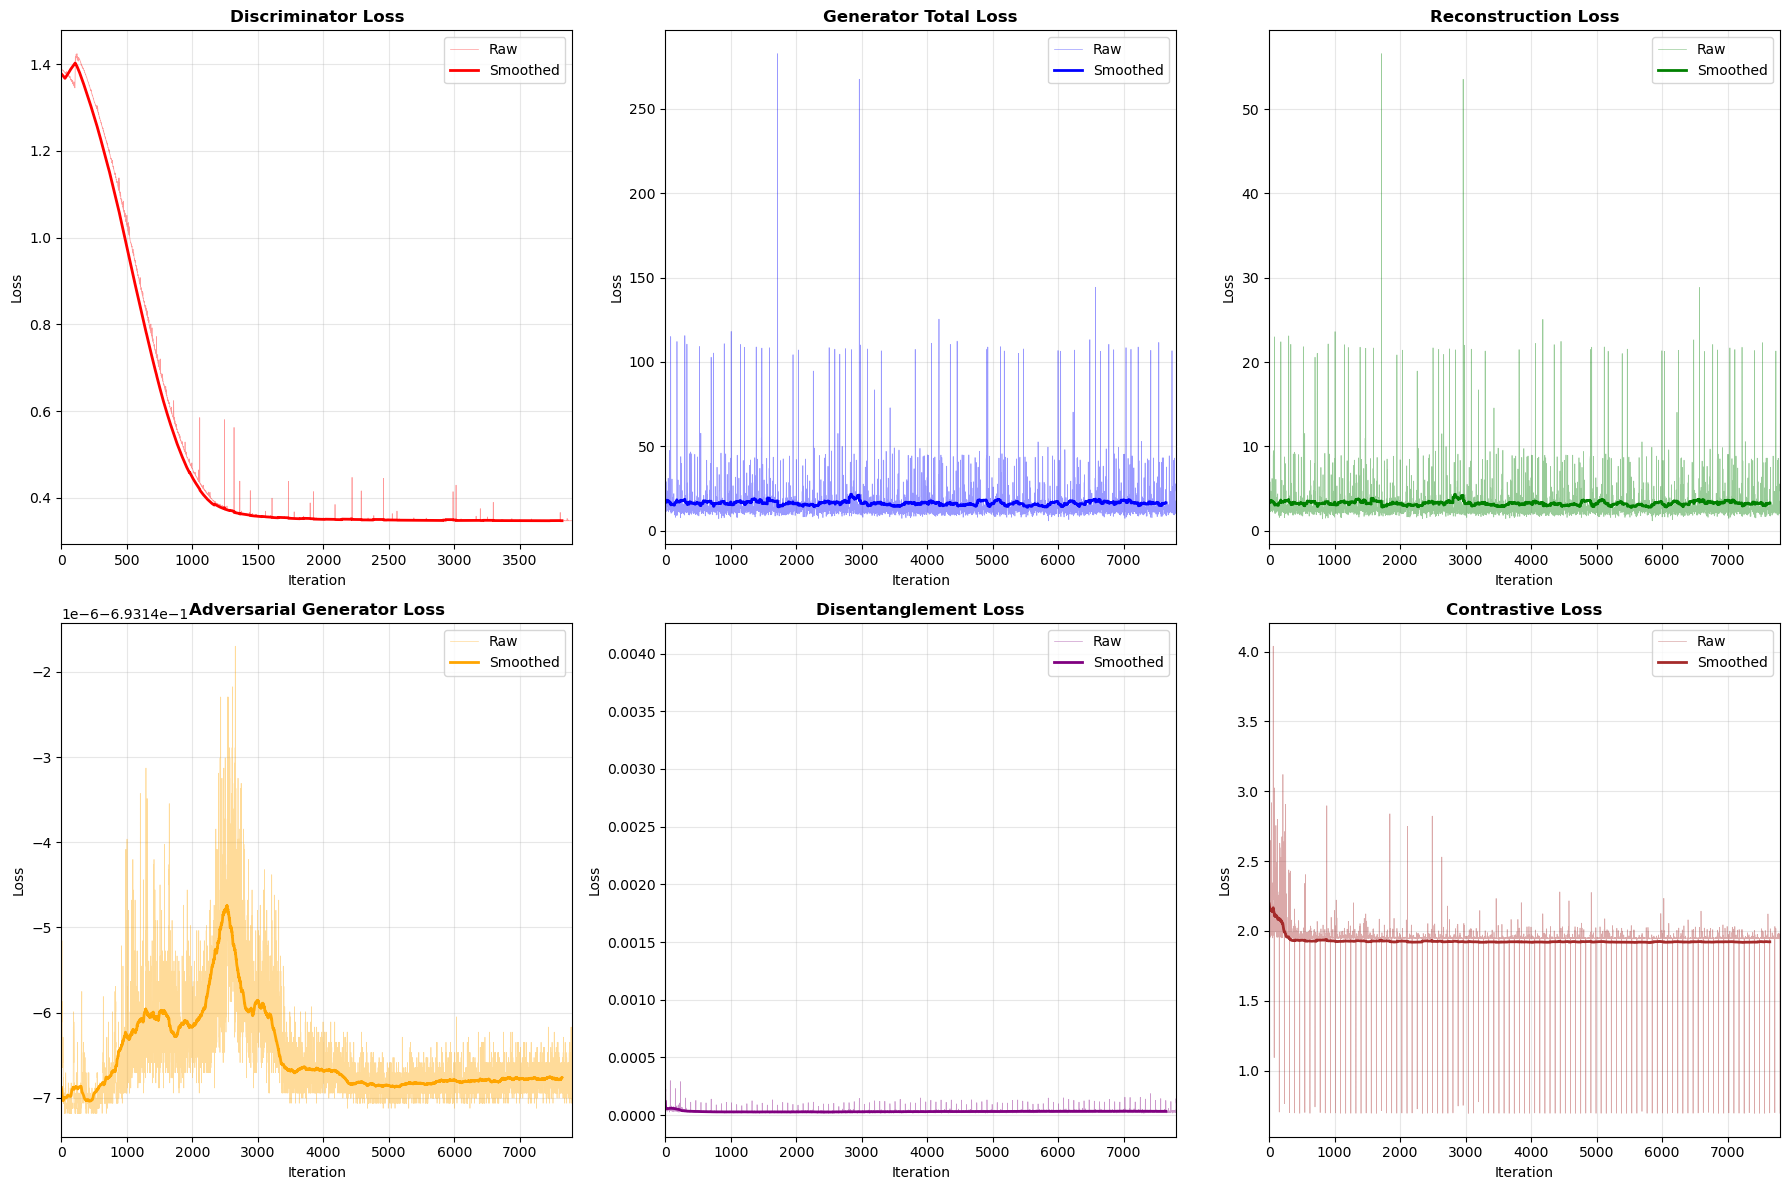

📈 Loss curves saved to: checkpoints\loss_curves.png

🎯 Training completed!
   Total epochs processed: 100
   Final consecutive NaN count: 0
   Checkpoints saved in: checkpoints
   Final GPU memory: 384.6 MB
🎉 Training session finished successfully!


In [ ]:
# main train loop
print("🚀 Starting training with enhanced NaN protection...")
print(f"📊 Configuration: {config}")


loss_history = {
    'total_G': [],
    'disc': [],
    'disent': [],
    'cont': [],
    'margin': [],
    'recon': [],
    'adv_gen': []
}


consecutive_nan_count = 0
max_consecutive_nans = config["nan_threshold"]


models_dict = {
    'style_encoder': style_encoder,
    'content_encoder': content_encoder,
    'discriminator': discriminator,
    'decoder': decoder
}

optimizers_dict = {
    'optimizer_G': optimizer_G,
    'optimizer_D': optimizer_D
}

schedulers_dict = {
    'scheduler_G': scheduler_G,
    'scheduler_D': scheduler_D
}

try:
    for epoch in tqdm(range(config["epochs"]), desc="Training Progress"):
        # early stopping check for NaN
        if consecutive_nan_count >= max_consecutive_nans:
            print(f"🛑 Early stopping: {consecutive_nan_count} consecutive NaN occurrences")
            break
        
        # set all models to training mode
        for model in models:
            model.train()
        
        epoch_losses = {key: [] for key in loss_history.keys()}
        
        print(f"\n🔄 Epoch {epoch+1}/{config['epochs']}")
        print("-" * 60)
        
        for batch_idx, (x, labels) in enumerate(train_loader):
            x = x.to(device)
            labels = labels.to(device)
            
            # Controllo NaN nei dati di input
            if check_for_nan(x, labels, names=["input_x", "input_labels"]):
                print(f"⚠️  Skipping batch {batch_idx} due to NaN in input data")
                continue
            
            # ============================================
            # DISCRIMINATOR training
            # ============================================
            for _ in range(config["discriminator_steps"]):
                disc_loss = discriminator_training_step(x, labels, epoch)
                
                # NaN
                if not np.isnan(disc_loss):
                    epoch_losses['disc'].append(disc_loss)
                    consecutive_nan_count = 0  # Reset counter 
                else:
                    consecutive_nan_count += 1
                    print(f"⚠️  NaN in discriminator loss (consecutive: {consecutive_nan_count})")
            



            # ============================================
            # GENERATORS training
            # ============================================
            for _ in range(config["generator_steps"]):
                gen_losses = generator_training_step(x, labels, epoch)
                
                # NaN
                nan_in_gen = any(np.isnan(v) for v in gen_losses.values())
                
                if not nan_in_gen:
                    for key, value in gen_losses.items():
                        if key in epoch_losses:
                            epoch_losses[key].append(value)
                    consecutive_nan_count = 0  # Reset counter su successo
                else:
                    consecutive_nan_count += 1
                    print(f"⚠️  NaN in generator losses (consecutive: {consecutive_nan_count})")
            



            # batch logging
            if batch_idx % 25 == 0:
                print(f"\n📊 Batch {batch_idx + 1}:")
                
                # disc loss
                if epoch_losses['disc']:
                    recent_disc = epoch_losses['disc'][-config["discriminator_steps"]:]
                    avg_disc = np.mean(recent_disc)
                    print(f"   Discriminator Loss: {avg_disc:.6f}")
                
                # gen loss
                if epoch_losses['total_G']:
                    recent_gen = epoch_losses['total_G'][-config["generator_steps"]:]
                    avg_total_G = np.mean(recent_gen)
                    print(f"   Generator Total Loss: {avg_total_G:.6f}")
                
                # individual losses
                gen_loss_names = ['adv_gen', 'disent', 'cont', 'margin', 'recon']
                for loss_name in gen_loss_names:
                    if epoch_losses[loss_name]:
                        recent_loss = epoch_losses[loss_name][-config["generator_steps"]:]
                        avg_loss = np.mean(recent_loss)
                        print(f"     {loss_name.replace('_', ' ').title()}: {avg_loss:.6f}")
                

                print(f"   Consecutive NaN count: {consecutive_nan_count}")
                if torch.cuda.is_available():
                    print(f"   GPU Memory: {torch.cuda.memory_allocated()/1024**2:.1f} MB")
            
            # NaN
            if consecutive_nan_count >= max_consecutive_nans:
                print(f"🛑 Stopping epoch {epoch+1} due to consecutive NaN issues")
                break
        
        # ============================================
        # update and save
        # ============================================
        if consecutive_nan_count < max_consecutive_nans:
            # update schedulers
            if epoch_losses['disc']:
                scheduler_D.step(np.mean(epoch_losses['disc']))
            if epoch_losses['total_G']:
                scheduler_G.step(np.mean(epoch_losses['total_G']))
            
            # add loss
            for key in loss_history.keys():
                if epoch_losses[key]:
                    loss_history[key].extend(epoch_losses[key])
            
            # save checkpoint
            if (epoch + 1) % config["save_interval"] == 0:
                save_checkpoint(epoch + 1, models_dict, optimizers_dict, schedulers_dict, config)
            
            # epoch summary
            print(f"\n✅ Epoch {epoch+1} Summary:")
            print("-" * 40)
            
            for key in ['disc', 'total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']:
                if epoch_losses[key]:
                    avg_loss = np.mean(epoch_losses[key])
                    print(f"   {key.replace('_', ' ').title()}: {avg_loss:.6f}")
            
            current_lr_G = optimizer_G.param_groups[0]['lr']
            current_lr_D = optimizer_D.param_groups[0]['lr']
            print(f"   LR Generator: {current_lr_G:.2e}")
            print(f"   LR Discriminator: {current_lr_D:.2e}")
            
            print("-" * 60)
        
        # memory clean
        if torch.cuda.is_available() and epoch % 10 == 0:
            torch.cuda.empty_cache()

except KeyboardInterrupt:
    print("\n⏹️  Training interrupted by user")
except Exception as e:
    print(f"\n❌ Training error: {e}")
    import traceback
    traceback.print_exc()
finally:
    # final save
    print("\n💾 Saving final checkpoint...")
    save_checkpoint(epoch + 1, models_dict, optimizers_dict, schedulers_dict, config)
    
    # Visualizzazione delle loss
    if any(loss_history[key] for key in loss_history.keys()):
        print("📊 Generating loss plots...")
        
        # Configura plot
        plt.style.use('default')
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        # Definisci le loss da plottare
        loss_configs = [
            ('disc', 'Discriminator Loss', 'red'),
            ('total_G', 'Generator Total Loss', 'blue'),
            ('recon', 'Reconstruction Loss', 'green'),
            ('adv_gen', 'Adversarial Generator Loss', 'orange'),
            ('disent', 'Disentanglement Loss', 'purple'),
            ('cont', 'Contrastive Loss', 'brown')
        ]
        
        for i, (loss_name, title, color) in enumerate(loss_configs):
            if loss_history[loss_name]:
                values = loss_history[loss_name]
                
                # Plot raw values
                axes[i].plot(values, alpha=0.4, color=color, linewidth=0.5, label='Raw')
                
                # Plot smoothed values se ci sono abbastanza punti
                if len(values) > 50:
                    window = max(1, len(values) // 50)
                    smoothed = np.convolve(values, np.ones(window)/window, mode='valid')
                    axes[i].plot(smoothed, color=color, linewidth=2, label='Smoothed')
                
                axes[i].set_title(title, fontsize=12, fontweight='bold')
                axes[i].set_xlabel('Iteration')
                axes[i].set_ylabel('Loss')
                axes[i].legend()
                axes[i].grid(True, alpha=0.3)
                axes[i].set_xlim(0, len(values))
        
        plt.tight_layout()
        plot_path = os.path.join(config["save_dir"], "loss_curves.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"📈 Loss curves saved to: {plot_path}")
    
    # Riepilogo finale
    print(f"\n🎯 Training completed!")
    print(f"   Total epochs processed: {epoch + 1}")
    print(f"   Final consecutive NaN count: {consecutive_nan_count}")
    print(f"   Checkpoints saved in: {config['save_dir']}")
    
    if torch.cuda.is_available():
        print(f"   Final GPU memory: {torch.cuda.memory_allocated()/1024**2:.1f} MB")
    
    print("🎉 Training session finished successfully!")

In [ ]:
# TO DO
# CURRICULUM LEARNING
def get_curriculum_weights(epoch, total_epochs):
    """
    Curriculum learning progressivo - migliore del pre-training separato
    """
    progress = epoch / total_epochs
    
    # Fase 1: Solo ricostruzione (0-20%)
    if progress < 0.2:
        return {
            "lambda_recon": 10.0,
            "lambda_adv_gen": 0.0,
            "lambda_adv_disc": 0.0,
            "lambda_disent": 0.0,
            "lambda_cont": 0.0,
            "lambda_margin": 0.0
        }
    
    # Fase 2: Aggiungi disentanglement (20-40%)
    elif progress < 0.4:
        return {
            "lambda_recon": 8.0,
            "lambda_adv_gen": 0.0,
            "lambda_adv_disc": 0.0,
            "lambda_disent": 0.5,
            "lambda_cont": 0.0,
            "lambda_margin": 0.0
        }
    
    # Fase 3: Aggiungi contrastive learning (40-60%)
    elif progress < 0.6:
        return {
            "lambda_recon": 5.0,
            "lambda_adv_gen": 0.0,
            "lambda_adv_disc": 0.0,
            "lambda_disent": 0.8,
            "lambda_cont": 0.2,
            "lambda_margin": 0.1
        }
    
    # Fase 4: Introduci adversarial training gradualmente (60-100%)
    else:
        # Crescita graduale dell'adversarial loss
        adv_strength = min(1.0, (progress - 0.6) / 0.4)
        return {
            "lambda_recon": 3.0,
            "lambda_adv_gen": 0.3 * adv_strength,
            "lambda_adv_disc": 0.5 * adv_strength,
            "lambda_disent": 0.8,
            "lambda_cont": 0.1,
            "lambda_margin": 0.05
        }
    


import torch.nn.utils.spectral_norm as spectral_norm

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            spectral_norm(nn.Linear(input_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(hidden_dim, hidden_dim//2)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(hidden_dim//2, 1))
        )

In [ ]:
def generator_training_step_curriculum(x, labels, epoch, total_epochs):
    """
    Step di training con curriculum learning integrato
    """
    # Ottieni pesi curriculum per l'epoca corrente
    curriculum_weights = get_curriculum_weights(epoch, total_epochs)
    
    # Abilita gradienti per i generatori
    set_requires_grad([style_encoder, content_encoder, decoder], True)
    set_requires_grad(discriminator, False)
    
    try:
        # Forward pass
        style_emb, class_emb = style_encoder(x, labels)
        content_emb = content_encoder(x)
        
        # Controllo NaN
        if check_for_nan(style_emb, class_emb, content_emb,
                         names=["style_emb", "class_emb", "content_emb"]):
            return {key: float('nan') for key in curriculum_weights.keys()}
        
        # Calcola solo le loss attive nel curriculum
        losses = {}
        
        # Loss di ricostruzione (sempre attiva)
        if curriculum_weights["lambda_recon"] > 0:
            stft_part = x[:, :, :, :, :513]
            recon_x = decoder(content_emb, style_emb, y=stft_part)
            recon_losses = compute_comprehensive_loss(recon_x, stft_part)
            losses["recon"] = recon_losses['total_loss']
        
        # Loss di disentanglement
        if curriculum_weights["lambda_disent"] > 0:
            losses["disent"] = disentanglement_loss(
                style_emb, content_emb.mean(dim=1), use_hsic=True
            )
        
        # Loss contrastiva
        if curriculum_weights["lambda_cont"] > 0:
            losses["cont"] = infoNCE_loss(style_emb, labels)
        
        # Margin loss
        if curriculum_weights["lambda_margin"] > 0:
            losses["margin"] = margin_loss(class_emb)
        
        # Loss avversariale (solo quando attivata)
        if curriculum_weights["lambda_adv_gen"] > 0:
            _, losses["adv_gen"] = adversarial_loss(
                style_emb, class_emb, content_emb, discriminator, labels,
                compute_for_discriminator=False,
                lambda_content=curriculum_weights["lambda_adv_gen"]
            )
        
        # Controlla NaN in tutte le loss calcolate
        if check_for_nan(*losses.values(), names=list(losses.keys())):
            return {key: float('nan') for key in curriculum_weights.keys()}
        
        # Calcola loss totale usando i pesi del curriculum
        total_G_loss = sum(
            curriculum_weights[f"lambda_{key}"] * loss_val
            for key, loss_val in losses.items()
            if f"lambda_{key}" in curriculum_weights
        )
        
        # Backpropagation
        optimizer_G.zero_grad()
        total_G_loss.backward()
        
        # Gradient clipping
        generator_params = (
            list(style_encoder.parameters()) + 
            list(content_encoder.parameters()) +
            list(decoder.parameters())
        )
        torch.nn.utils.clip_grad_norm_(generator_params, config["grad_clip_value"])
        
        optimizer_G.step()
        
        # Prepara output con tutte le loss (0 se non attive)
        output_losses = {
            'total_G': total_G_loss.item(),
            'recon': losses.get("recon", torch.tensor(0.0)).item(),
            'disent': losses.get("disent", torch.tensor(0.0)).item(),
            'cont': losses.get("cont", torch.tensor(0.0)).item(),
            'margin': losses.get("margin", torch.tensor(0.0)).item(),
            'adv_gen': losses.get("adv_gen", torch.tensor(0.0)).item()
        }
        
        return output_losses
        
    except Exception as e:
        print(f"❌ Error in generator training step: {e}")
        return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}

## Train with curriculum

In [ ]:
def get_curriculum_weights(epoch, total_epochs):
    progress = epoch / total_epochs
    
    # phase 1 (0-20%): only reconstruction
    if progress < 0.2:
        return {
            "lambda_recon": 10.0,
            "lambda_adv_gen": 0.0,
            "lambda_adv_disc": 0.0,
            "lambda_disent": 0.0,
            "lambda_cont": 0.0,
            "lambda_margin": 0.0
        }
    
    # phase 2 (20-40%): add disentanglement
    elif progress < 0.4:
        return {
            "lambda_recon": 8.0,
            "lambda_adv_gen": 0.0,
            "lambda_adv_disc": 0.0,
            "lambda_disent": 0.5,
            "lambda_cont": 0.0,
            "lambda_margin": 0.0
        }
    
    # phase 2 (40-60%): add contrastive learning
    elif progress < 0.6:
        return {
            "lambda_recon": 5.0,
            "lambda_adv_gen": 0.0,
            "lambda_adv_disc": 0.0,
            "lambda_disent": 0.8,
            "lambda_cont": 0.2,
            "lambda_margin": 0.1
        }
    
    # phase 4 (60-100%): introduce adversarial training gradually
    else:
        # gradual increase of adversarial loss
        adv_strength = min(1.0, (progress - 0.6) / 0.4)
        return {
            "lambda_recon": 3.0,
            "lambda_adv_gen": 0.3 * adv_strength,
            "lambda_adv_disc": 0.5 * adv_strength,
            "lambda_disent": 0.8,
            "lambda_cont": 0.1,
            "lambda_margin": 0.05
        }

In [ ]:
def discriminator_training_step_curriculum(x, labels, epoch, total_epochs):
    """
    Step di training per il discriminatore con curriculum learning
    """
    # Ottieni pesi curriculum
    curriculum_weights = get_curriculum_weights(epoch, total_epochs)
    
    # Salta training del discriminatore se non è ancora attivo
    if curriculum_weights["lambda_adv_disc"] == 0:
        return 0.0
    
    # Abilita gradienti solo per discriminatore
    set_requires_grad(discriminator, True)
    set_requires_grad([style_encoder, content_encoder, decoder], False)
    
    try:
        # Forward pass senza gradienti per i generatori
        with torch.no_grad():
            style_emb, class_emb = style_encoder(x, labels)
            content_emb = content_encoder(x)
        
        # Controllo NaN negli embeddings
        if check_for_nan(style_emb, class_emb, content_emb, 
                         names=["style_emb", "class_emb", "content_emb"]):
            return float('nan')
        
        # Calcola loss del discriminatore
        disc_loss, _ = adversarial_loss(
            style_emb.detach(),
            class_emb.detach(),
            content_emb.detach(),
            discriminator,
            labels,
            compute_for_discriminator=True,
            lambda_content=curriculum_weights["lambda_adv_disc"]
        )
        
        # Controllo NaN nella loss
        if check_for_nan(disc_loss, names=["disc_loss"]):
            return float('nan')
        
        # Backpropagation
        optimizer_D.zero_grad()
        disc_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), config["grad_clip_value"])
        
        optimizer_D.step()
        return disc_loss.item()
        
    except Exception as e:
        print(f"❌ Error in discriminator training step: {e}")
        return float('nan')

def generator_training_step_curriculum(x, labels, epoch, total_epochs):
    """
    Step di training per i generatori con curriculum learning
    """
    # Ottieni pesi curriculum per l'epoca corrente
    curriculum_weights = get_curriculum_weights(epoch, total_epochs)
    
    # Abilita gradienti per i generatori
    set_requires_grad([style_encoder, content_encoder, decoder], True)
    set_requires_grad(discriminator, False)
    
    try:
        # Forward pass
        style_emb, class_emb = style_encoder(x, labels)
        content_emb = content_encoder(x)
        
        # Controllo NaN
        if check_for_nan(style_emb, class_emb, content_emb,
                         names=["style_emb", "class_emb", "content_emb"]):
            return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}
        
        # Calcola solo le loss attive nel curriculum
        losses = {}
        
        # Loss di ricostruzione (sempre attiva)
        if curriculum_weights["lambda_recon"] > 0:
            stft_part = x[:, :, :, :, :513]
            recon_x = decoder(content_emb, style_emb, y=stft_part)
            recon_losses = compute_comprehensive_loss(recon_x, stft_part)
            losses["recon"] = recon_losses['total_loss']
        
        # Loss di disentanglement
        if curriculum_weights["lambda_disent"] > 0:
            losses["disent"] = disentanglement_loss(
                style_emb, content_emb.mean(dim=1), use_hsic=True
            )
        
        # Loss contrastiva
        if curriculum_weights["lambda_cont"] > 0:
            losses["cont"] = infoNCE_loss(style_emb, labels)
        
        # Margin loss
        if curriculum_weights["lambda_margin"] > 0:
            losses["margin"] = margin_loss(class_emb)
        
        # Loss avversariale (solo quando attivata)
        if curriculum_weights["lambda_adv_gen"] > 0:
            _, losses["adv_gen"] = adversarial_loss(
                style_emb, class_emb, content_emb, discriminator, labels,
                compute_for_discriminator=False,
                lambda_content=curriculum_weights["lambda_adv_gen"]
            )
        
        # Controlla NaN in tutte le loss calcolate
        if check_for_nan(*losses.values(), names=list(losses.keys())):
            return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}
        
        # Calcola loss totale usando i pesi del curriculum
        total_G_loss = sum(
            curriculum_weights[f"lambda_{key}"] * loss_val
            for key, loss_val in losses.items()
            if f"lambda_{key}" in curriculum_weights
        )
        
        # Backpropagation
        optimizer_G.zero_grad()
        total_G_loss.backward()
        
        # Gradient clipping
        generator_params = (
            list(style_encoder.parameters()) + 
            list(content_encoder.parameters()) +
            list(decoder.parameters())
        )
        torch.nn.utils.clip_grad_norm_(generator_params, config["grad_clip_value"])
        
        optimizer_G.step()
        
        # Prepara output con tutte le loss (0 se non attive)
        output_losses = {
            'total_G': total_G_loss.item(),
            'recon': losses.get("recon", torch.tensor(0.0)).item(),
            'disent': losses.get("disent", torch.tensor(0.0)).item(),
            'cont': losses.get("cont", torch.tensor(0.0)).item(),
            'margin': losses.get("margin", torch.tensor(0.0)).item(),
            'adv_gen': losses.get("adv_gen", torch.tensor(0.0)).item()
        }
        
        return output_losses
        
    except Exception as e:
        print(f"❌ Error in generator training step: {e}")
        return {key: float('nan') for key in ['total_G', 'adv_gen', 'disent', 'cont', 'margin', 'recon']}

In [ ]:
def train_with_curriculum():
    """
    Training principale con curriculum learning integrato
    """
    print("🚀 Starting curriculum learning training...")
    
    # Inizializza strutture per il tracking delle loss
    loss_history = {
        'total_G': [],
        'disc': [],
        'disent': [],
        'cont': [],
        'margin': [],
        'recon': [],
        'adv_gen': []
    }
    
    # Contatore per NaN consecutivi
    consecutive_nan_count = 0
    max_consecutive_nans = config["nan_threshold"]
    
    # Dizionari per salvataggio
    models_dict = {
        'style_encoder': style_encoder,
        'content_encoder': content_encoder,
        'discriminator': discriminator,
        'decoder': decoder
    }
    
    optimizers_dict = {
        'optimizer_G': optimizer_G,
        'optimizer_D': optimizer_D
    }
    
    schedulers_dict = {
        'scheduler_G': scheduler_G,
        'scheduler_D': scheduler_D
    }
    
    try:
        for epoch in tqdm(range(config["epochs"]), desc="Curriculum Training"):
            # Controllo early stopping per NaN
            if consecutive_nan_count >= max_consecutive_nans:
                print(f"🛑 Early stopping: {consecutive_nan_count} consecutive NaN occurrences")
                break
            
            # Ottieni pesi curriculum per l'epoca corrente
            curriculum_weights = get_curriculum_weights(epoch, config["epochs"])
            
            # Imposta tutti i modelli in modalità training
            for model in models:
                model.train()
            
            # Tracking delle loss per l'epoca corrente
            epoch_losses = {key: [] for key in loss_history.keys()}
            
            # Stampa fase corrente del curriculum
            progress = epoch / config["epochs"]
            if progress < 0.2:
                phase = "Fase 1: Solo Ricostruzione"
            elif progress < 0.4:
                phase = "Fase 2: + Disentanglement"
            elif progress < 0.6:
                phase = "Fase 3: + Contrastive Learning"
            else:
                phase = "Fase 4: + Adversarial Training"
            
            print(f"\n🔄 Epoch {epoch+1}/{config['epochs']} - {phase}")
            print(f"📊 Curriculum weights: {curriculum_weights}")
            print("-" * 60)
            
            for batch_idx, (x, labels) in enumerate(train_loader):
                # Trasferisce dati su GPU
                x = x.to(device)
                labels = labels.to(device)
                
                # Controllo NaN nei dati di input
                if check_for_nan(x, labels, names=["input_x", "input_labels"]):
                    print(f"⚠️  Skipping batch {batch_idx} due to NaN in input data")
                    continue
                
                # ============================================
                # TRAINING DISCRIMINATORE (solo se attivo)
                # ============================================
                if curriculum_weights["lambda_adv_disc"] > 0:
                    for _ in range(config["discriminator_steps"]):
                        disc_loss = discriminator_training_step_curriculum(x, labels, epoch, config["epochs"])
                        
                        if not np.isnan(disc_loss):
                            epoch_losses['disc'].append(disc_loss)
                            consecutive_nan_count = 0
                        else:
                            consecutive_nan_count += 1
                            print(f"⚠️  NaN in discriminator loss (consecutive: {consecutive_nan_count})")
                
                # ============================================
                # TRAINING GENERATORE
                # ============================================
                for _ in range(config["generator_steps"]):
                    gen_losses = generator_training_step_curriculum(x, labels, epoch, config["epochs"])
                    
                    # Controlla se ci sono NaN nelle loss del generatore
                    nan_in_gen = any(np.isnan(v) for v in gen_losses.values())
                    
                    if not nan_in_gen:
                        # Aggiungi loss valide alla storia
                        for key, value in gen_losses.items():
                            if key in epoch_losses:
                                epoch_losses[key].append(value)
                        consecutive_nan_count = 0
                    else:
                        consecutive_nan_count += 1
                        print(f"⚠️  NaN in generator losses (consecutive: {consecutive_nan_count})")
                
                # ============================================
                # LOGGING PER BATCH
                # ============================================
                if batch_idx % 25 == 0:
                    print(f"\n📊 Batch {batch_idx + 1}:")
                    
                    # Solo loss attive nel curriculum
                    if curriculum_weights["lambda_adv_disc"] > 0 and epoch_losses['disc']:
                        recent_disc = epoch_losses['disc'][-config["discriminator_steps"]:]
                        avg_disc = np.mean(recent_disc)
                        print(f"   Discriminator Loss: {avg_disc:.6f}")
                    
                    if epoch_losses['total_G']:
                        recent_gen = epoch_losses['total_G'][-config["generator_steps"]:]
                        avg_total_G = np.mean(recent_gen)
                        print(f"   Generator Total Loss: {avg_total_G:.6f}")
                    
                    # Loss individuali attive
                    for loss_name, weight_key in [
                        ('recon', 'lambda_recon'),
                        ('disent', 'lambda_disent'),
                        ('cont', 'lambda_cont'),
                        ('margin', 'lambda_margin'),
                        ('adv_gen', 'lambda_adv_gen')
                    ]:
                        if curriculum_weights[weight_key] > 0 and epoch_losses[loss_name]:
                            recent_loss = epoch_losses[loss_name][-config["generator_steps"]:]
                            avg_loss = np.mean(recent_loss)
                            print(f"     {loss_name.replace('_', ' ').title()}: {avg_loss:.6f}")
                
                # Controllo early stopping durante il batch
                if consecutive_nan_count >= max_consecutive_nans:
                    print(f"🛑 Stopping epoch {epoch+1} due to consecutive NaN issues")
                    break
            
            # ============================================
            # FINE EPOCA: AGGIORNAMENTI E SALVATAGGIO
            # ============================================
            if consecutive_nan_count < max_consecutive_nans:
                # Aggiorna schedulers
                if epoch_losses['disc']:
                    scheduler_D.step(np.mean(epoch_losses['disc']))
                if epoch_losses['total_G']:
                    scheduler_G.step(np.mean(epoch_losses['total_G']))
                
                # Aggiungi loss dell'epoca alla storia globale
                for key in loss_history.keys():
                    if epoch_losses[key]:
                        loss_history[key].extend(epoch_losses[key])
                
                # Salva checkpoint periodicamente
                if (epoch + 1) % config["save_interval"] == 0:
                    save_checkpoint(epoch + 1, models_dict, optimizers_dict, schedulers_dict, config)
                
                # Riepilogo dell'epoca
                print(f"\n✅ Epoch {epoch+1} Summary:")
                print("-" * 40)
                
                # Mostra solo loss attive
                for key, weight_key in [
                    ('disc', 'lambda_adv_disc'),
                    ('total_G', None),
                    ('recon', 'lambda_recon'),
                    ('disent', 'lambda_disent'),
                    ('cont', 'lambda_cont'),
                    ('margin', 'lambda_margin'),
                    ('adv_gen', 'lambda_adv_gen')
                ]:
                    if (weight_key is None or curriculum_weights[weight_key] > 0) and epoch_losses[key]:
                        avg_loss = np.mean(epoch_losses[key])
                        print(f"   {key.replace('_', ' ').title()}: {avg_loss:.6f}")
                
                print("-" * 60)
            
            # Pulizia memoria periodica
            if torch.cuda.is_available() and epoch % 10 == 0:
                torch.cuda.empty_cache()
    
    except KeyboardInterrupt:
        print("\n⏹️  Training interrupted by user")
    except Exception as e:
        print(f"\n❌ Training error: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # Salvataggio finale
        print("\n💾 Saving final checkpoint...")
        save_checkpoint(epoch + 1, models_dict, optimizers_dict, schedulers_dict, config)
        
        print("🎉 Curriculum learning training completed!")
        return loss_history

# ================================================================
# AVVIO DEL TRAINING CON CURRICULUM LEARNING
# ================================================================

# Sostituisci il loop di training originale con questo:
loss_history = train_with_curriculum()

## Small test

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

def visualize_reconstruction(models_dict, train_loader, device, num_samples=2, save_path=None):
    """
    Visualizza e confronta originale vs ricostruzione per alcuni campioni casuali.
    
    Args:
        models_dict: dizionario con i modelli {'style_encoder': ..., 'content_encoder': ..., 'decoder': ...}
        train_loader: DataLoader per il training
        device: dispositivo (cuda/cpu)
        num_samples: numero di campioni da visualizzare
        save_path: path dove salvare le immagini (opzionale)
    """
    
    # Estrai i modelli
    style_encoder = models_dict['style_encoder']
    content_encoder = models_dict['content_encoder']
    decoder = models_dict['decoder']
    
    # Metti i modelli in modalità eval
    style_encoder.eval()
    content_encoder.eval()
    decoder.eval()
    
    print(f"🎯 Visualizing {num_samples} reconstruction examples...")
    
    with torch.no_grad():
        # Prendi un batch casuale
        batch_iterator = iter(train_loader)
        x, labels = next(batch_iterator)
        
        # Trasferisci su device
        x = x.to(device)
        labels = labels.to(device)
        
        print(f"📊 Batch shape: {x.shape}")
        print(f"📋 Labels: {labels}")
        
        # Limita al numero di campioni richiesto
        x = x[:num_samples]
        labels = labels[:num_samples]
        
        # Forward pass attraverso i modelli
        print("🔄 Forward pass attraverso i modelli...")
        
        # Encoding
        style_emb, class_emb = style_encoder(x, labels)
        content_emb = content_encoder(x)
        
        print(f"   Style embedding shape: {style_emb.shape}")
        print(f"   Class embedding shape: {class_emb.shape}")
        print(f"   Content embedding shape: {content_emb.shape}")
        
        # Estrai la parte STFT (prime 513 frequenze)
        stft_original = x[:, :, :, :, :513]  # (batch, sections, channels, time, freq)
        
        # Ricostruzione
        print("🔧 Generating reconstruction...")
        reconstructed = decoder(content_emb, style_emb, y=stft_original)
        
        print(f"   Original STFT shape: {stft_original.shape}")
        print(f"   Reconstructed shape: {reconstructed.shape}")
        
        # Visualizza ogni campione
        for i in range(num_samples):
            print(f"\n📈 Visualizing sample {i+1}/{num_samples} (Label: {labels[i].item()})")
            
            # Prendi una sezione casuale (es. la prima)
            section_idx = 0
            
            original_section = stft_original[i, section_idx]  # (channels, time, freq)
            reconstructed_section = reconstructed[i, section_idx]  # (channels, time, freq)
            
            print(f"   Section {section_idx} - Original shape: {original_section.shape}")
            print(f"   Section {section_idx} - Reconstructed shape: {reconstructed_section.shape}")
            
            # Visualizza originale
            print(f"   📊 Original STFT - Sample {i+1}")
            plot_stft(original_section, log_scale=True)
            
            # Visualizza ricostruzione
            print(f"   🔧 Reconstructed STFT - Sample {i+1}")
            plot_stft(reconstructed_section, log_scale=True)
            
            # Calcola e visualizza la differenza
            print(f"   📉 Reconstruction Error - Sample {i+1}")
            plot_reconstruction_error(original_section, reconstructed_section)
            
            # Salva se richiesto
            if save_path:
                save_comparison_plots(original_section, reconstructed_section, 
                                    labels[i].item(), i, save_path)


def plot_reconstruction_error(original, reconstructed, sr=22050, hop_length=256):
    """
    Visualizza l'errore di ricostruzione.
    
    Args:
        original: tensor originale (channels, time, freq)
        reconstructed: tensor ricostruito (channels, time, freq)
        sr: sample rate
        hop_length: hop length per STFT
    """
    
    # Calcola magnitude per entrambi
    orig_real, orig_imag = original[0], original[1]
    recon_real, recon_imag = reconstructed[0], reconstructed[1]
    
    orig_magnitude = torch.hypot(orig_real, orig_imag)
    recon_magnitude = torch.hypot(recon_real, recon_imag)
    
    # Errore assoluto
    error = torch.abs(orig_magnitude - recon_magnitude)
    
    # Errore relativo (in dB)
    error_db = 20 * torch.log10(error + 1e-8)
    
    # Visualizza
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Errore assoluto
    plt.subplot(2, 2, 1)
    plt.imshow(
        error.T.cpu().numpy(),
        origin='lower',
        aspect='auto',
        extent=[0, original.shape[1] * hop_length / sr, 0, sr/2]
    )
    plt.colorbar(label='Absolute Error')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Absolute Reconstruction Error')
    
    # Subplot 2: Errore in dB
    plt.subplot(2, 2, 2)
    plt.imshow(
        error_db.T.cpu().numpy(),
        origin='lower',
        aspect='auto',
        extent=[0, original.shape[1] * hop_length / sr, 0, sr/2]
    )
    plt.colorbar(label='Error (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Reconstruction Error (dB)')
    
    # Subplot 3: Istogramma degli errori
    plt.subplot(2, 2, 3)
    error_flat = error.flatten().cpu().numpy()
    plt.hist(error_flat, bins=50, alpha=0.7, color='red')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.yscale('log')
    
    # Subplot 4: Statistiche
    plt.subplot(2, 2, 4)
    plt.axis('off')
    
    # Calcola statistiche
    mae = torch.mean(error).item()
    mse = torch.mean(error**2).item()
    rmse = torch.sqrt(torch.mean(error**2)).item()
    max_error = torch.max(error).item()
    
    # Calcola SNR
    signal_power = torch.mean(orig_magnitude**2)
    noise_power = torch.mean(error**2)
    snr_db = 10 * torch.log10(signal_power / noise_power).item()
    
    stats_text = f"""
    Reconstruction Statistics:
    
    MAE: {mae:.6f}
    MSE: {mse:.6f}
    RMSE: {rmse:.6f}
    Max Error: {max_error:.6f}
    
    SNR: {snr_db:.2f} dB
    
    Original Range: [{torch.min(orig_magnitude):.4f}, {torch.max(orig_magnitude):.4f}]
    Reconstructed Range: [{torch.min(recon_magnitude):.4f}, {torch.max(recon_magnitude):.4f}]
    """
    
    plt.text(0.1, 0.9, stats_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()


def save_comparison_plots(original, reconstructed, label, sample_idx, save_path):
    """
    Salva i plot di confronto su file.
    
    Args:
        original: tensor originale
        reconstructed: tensor ricostruito
        label: etichetta del campione
        sample_idx: indice del campione
        save_path: directory dove salvare
    """
    
    os.makedirs(save_path, exist_ok=True)
    
    # Calcola magnitudes
    orig_real, orig_imag = original[0], original[1]
    recon_real, recon_imag = reconstructed[0], reconstructed[1]
    
    orig_magnitude = torch.hypot(orig_real, orig_imag)
    recon_magnitude = torch.hypot(recon_real, recon_imag)
    
    # Converti in dB
    orig_db = 20 * torch.log10(orig_magnitude + 1e-8)
    recon_db = 20 * torch.log10(recon_magnitude + 1e-8)
    
    # Crea figura comparativa
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Originale
    im1 = axes[0].imshow(orig_db.T.cpu().numpy(), origin='lower', aspect='auto')
    axes[0].set_title(f'Original (Label: {label})')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Frequency')
    plt.colorbar(im1, ax=axes[0], label='Magnitude (dB)')
    
    # Ricostruzione
    im2 = axes[1].imshow(recon_db.T.cpu().numpy(), origin='lower', aspect='auto')
    axes[1].set_title(f'Reconstructed (Label: {label})')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Frequency')
    plt.colorbar(im2, ax=axes[1], label='Magnitude (dB)')
    
    # Differenza
    diff = torch.abs(orig_db - recon_db)
    im3 = axes[2].imshow(diff.T.cpu().numpy(), origin='lower', aspect='auto')
    axes[2].set_title(f'Absolute Difference (Label: {label})')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Frequency')
    plt.colorbar(im3, ax=axes[2], label='|Difference| (dB)')
    
    plt.tight_layout()
    
    # Salva
    filename = f'reconstruction_comparison_sample_{sample_idx}_label_{label}.png'
    filepath = os.path.join(save_path, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"   💾 Saved comparison plot: {filepath}")


def audio_reconstruction_test(models_dict, train_loader, device, num_samples=1):
    """
    Test completo che include anche la ricostruzione audio.
    
    Args:
        models_dict: dizionario con i modelli
        train_loader: DataLoader
        device: dispositivo
        num_samples: numero di campioni da testare
    """
    
    print("🎵 Testing audio reconstruction pipeline...")
    
    # Visualizza ricostruzioni spettrali
    visualize_reconstruction(models_dict, train_loader, device, num_samples)
    
    # Test ricostruzione audio (se hai le funzioni inverse)
    print("\n🔊 Testing audio reconstruction...")
    
    style_encoder = models_dict['style_encoder']
    content_encoder = models_dict['content_encoder']
    decoder = models_dict['decoder']
    
    style_encoder.eval()
    content_encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        batch_iterator = iter(train_loader)
        x, labels = next(batch_iterator)
        
        x = x.to(device)
        labels = labels.to(device)
        
        # Prendi un campione
        sample = x[0:1]  # (1, sections, channels, time, freq)
        sample_label = labels[0:1]
        
        # Forward pass
        style_emb, class_emb = style_encoder(sample, sample_label)
        content_emb = content_encoder(sample)
        
        # Ricostruzione
        stft_original = sample[:, :, :, :, :513]
        reconstructed = decoder(content_emb, style_emb, y=stft_original)
        
        print(f"🎯 Audio reconstruction test completed!")
        print(f"   Original shape: {stft_original.shape}")
        print(f"   Reconstructed shape: {reconstructed.shape}")
        
        # Qui potresti aggiungere la ricostruzione audio vera e propria
        # usando le tue funzioni inverse_STFT e sections2spectrogram
        
        return {
            'original': stft_original,
            'reconstructed': reconstructed,
            'style_emb': style_emb,
            'content_emb': content_emb,
            'label': sample_label
        }


# Esempio di utilizzo:
"""
# Dopo aver caricato i modelli
models_dict = {
    'style_encoder': style_encoder,
    'content_encoder': content_encoder,
    'decoder': decoder
}

# Visualizza ricostruzioni
visualize_reconstruction(models_dict, train_loader, device, num_samples=3)

# Test completo con salvataggio
visualize_reconstruction(models_dict, train_loader, device, 
                        num_samples=2, save_path="reconstruction_results")

# Test audio completo
results = audio_reconstruction_test(models_dict, train_loader, device)
"""

'\n# Dopo aver caricato i modelli\nmodels_dict = {\n    \'style_encoder\': style_encoder,\n    \'content_encoder\': content_encoder,\n    \'decoder\': decoder\n}\n\n# Visualizza ricostruzioni\nvisualize_reconstruction(models_dict, train_loader, device, num_samples=3)\n\n# Test completo con salvataggio\nvisualize_reconstruction(models_dict, train_loader, device, \n                        num_samples=2, save_path="reconstruction_results")\n\n# Test audio completo\nresults = audio_reconstruction_test(models_dict, train_loader, device)\n'

✅ Loaded separate statistics:
  Piano: train_set_stats/stats_stft_cqt_piano.npz
  Violin: train_set_stats/stats_stft_cqt_violin.npz
🎯 Visualizing 5 reconstruction examples...
📊 Batch shape: torch.Size([16, 3, 2, 287, 597])
📋 Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
🔄 Forward pass attraverso i modelli...
   Style embedding shape: torch.Size([5, 256])
   Class embedding shape: torch.Size([1, 256])
   Content embedding shape: torch.Size([5, 3, 256])
🔧 Generating reconstruction...
   Original STFT shape: torch.Size([5, 3, 2, 287, 513])
   Reconstructed shape: torch.Size([5, 3, 2, 287, 513])

📈 Visualizing sample 1/5 (Label: 0)
   Section 0 - Original shape: torch.Size([2, 287, 513])
   Section 0 - Reconstructed shape: torch.Size([2, 287, 513])
   📊 Original STFT - Sample 1


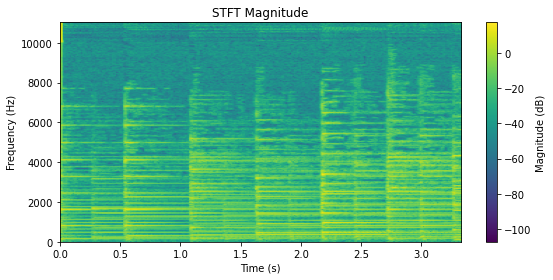

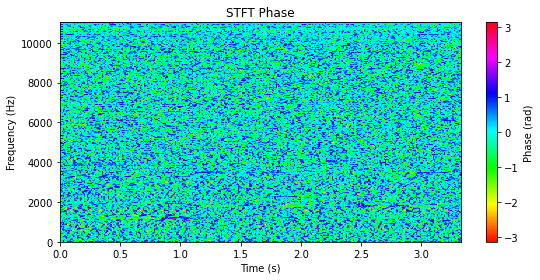

   🔧 Reconstructed STFT - Sample 1


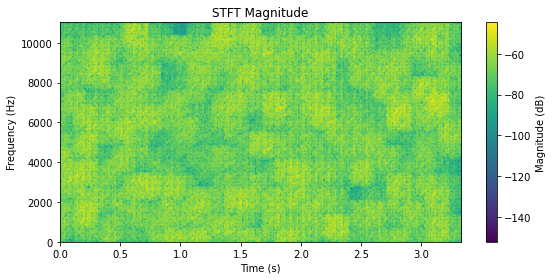

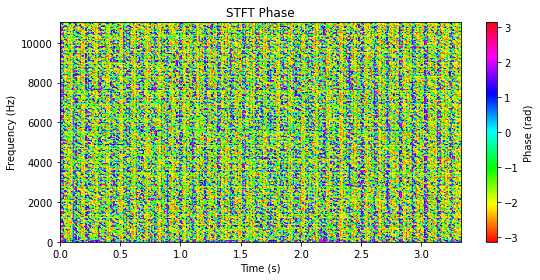

   📉 Reconstruction Error - Sample 1


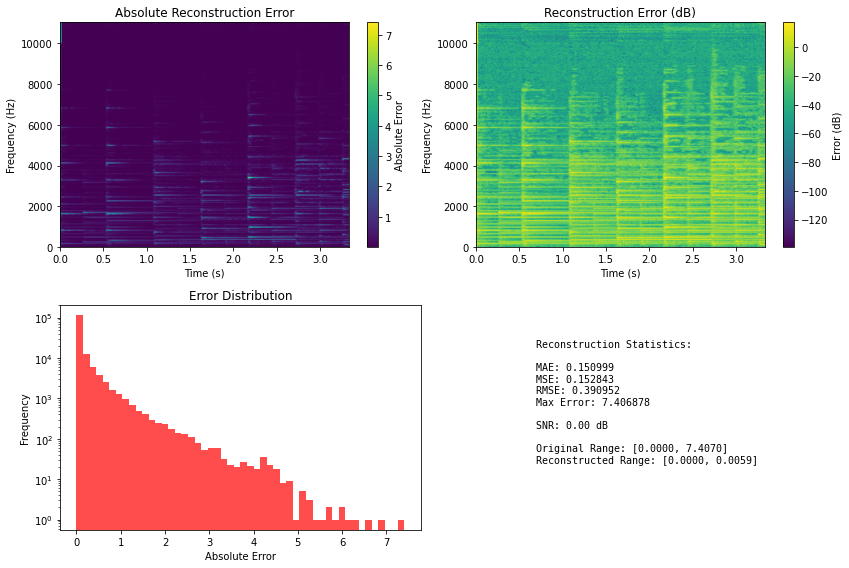


📈 Visualizing sample 2/5 (Label: 0)
   Section 0 - Original shape: torch.Size([2, 287, 513])
   Section 0 - Reconstructed shape: torch.Size([2, 287, 513])
   📊 Original STFT - Sample 2


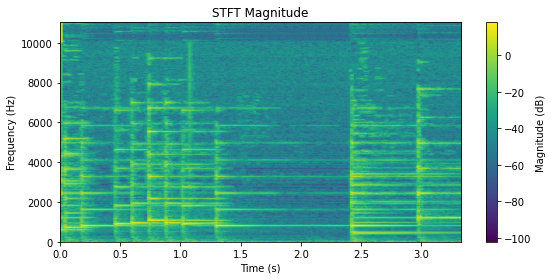

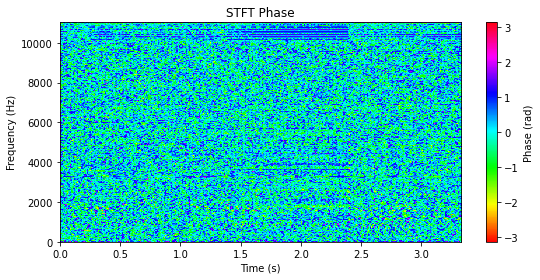

   🔧 Reconstructed STFT - Sample 2


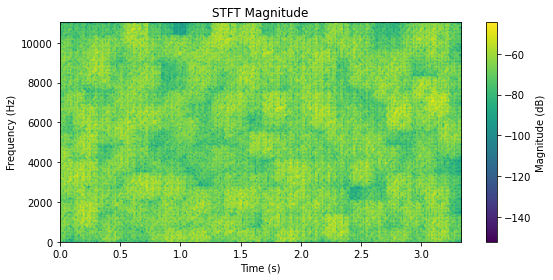

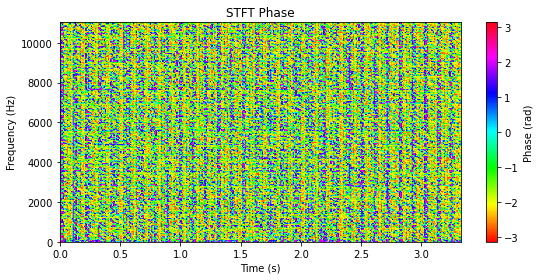

   📉 Reconstruction Error - Sample 2


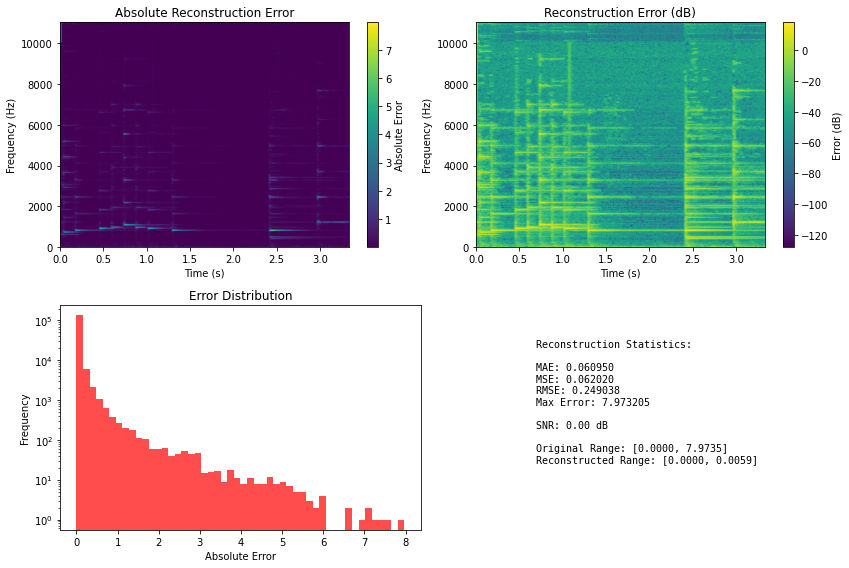


📈 Visualizing sample 3/5 (Label: 0)
   Section 0 - Original shape: torch.Size([2, 287, 513])
   Section 0 - Reconstructed shape: torch.Size([2, 287, 513])
   📊 Original STFT - Sample 3


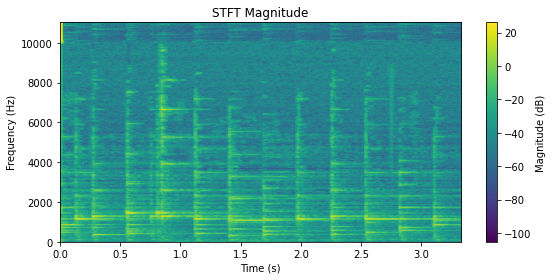

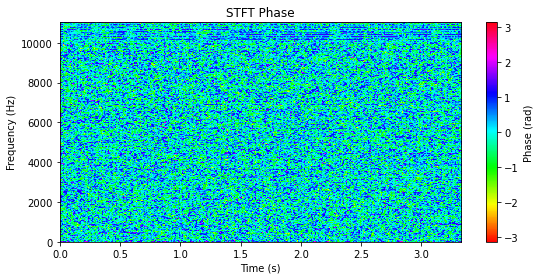

   🔧 Reconstructed STFT - Sample 3


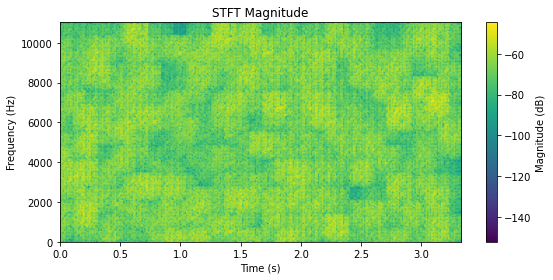

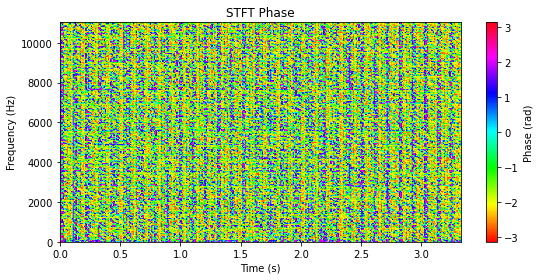

   📉 Reconstruction Error - Sample 3


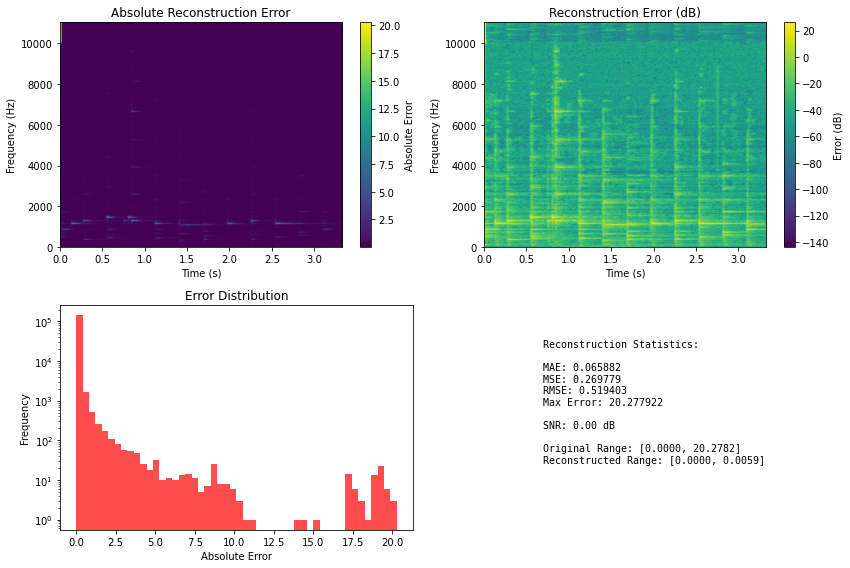


📈 Visualizing sample 4/5 (Label: 0)
   Section 0 - Original shape: torch.Size([2, 287, 513])
   Section 0 - Reconstructed shape: torch.Size([2, 287, 513])
   📊 Original STFT - Sample 4


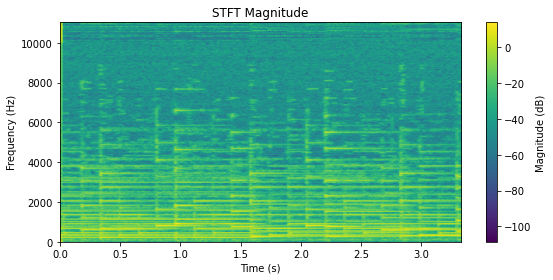

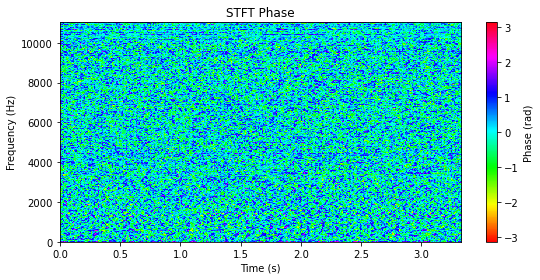

   🔧 Reconstructed STFT - Sample 4


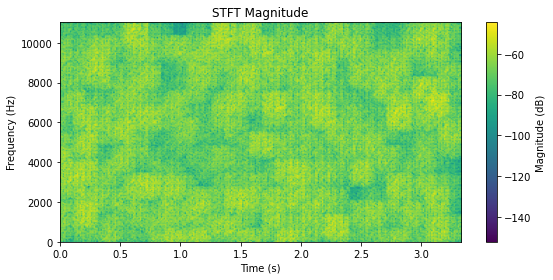

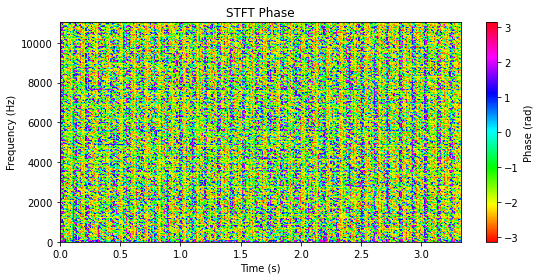

   📉 Reconstruction Error - Sample 4


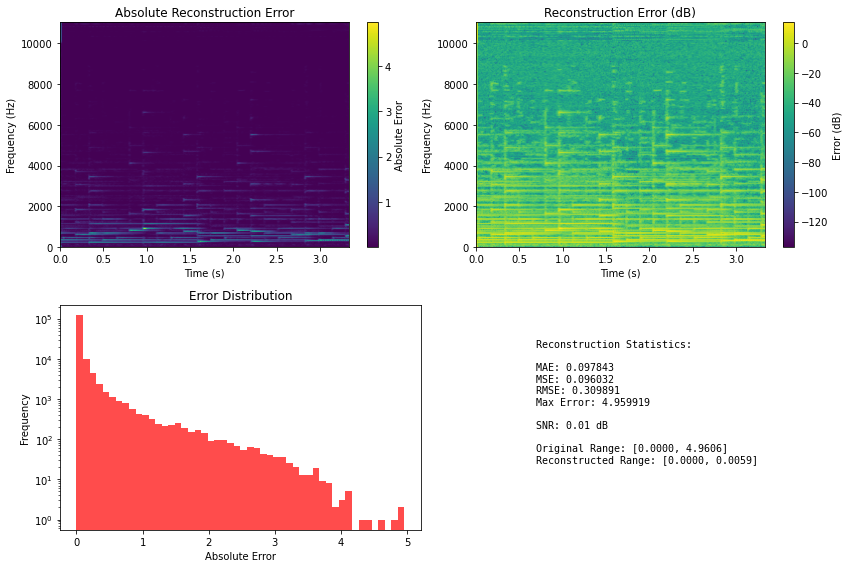


📈 Visualizing sample 5/5 (Label: 0)
   Section 0 - Original shape: torch.Size([2, 287, 513])
   Section 0 - Reconstructed shape: torch.Size([2, 287, 513])
   📊 Original STFT - Sample 5


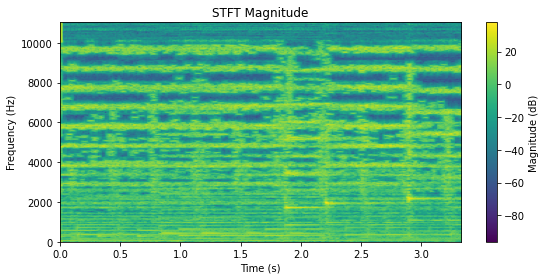

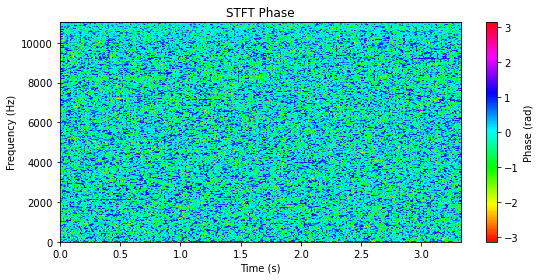

   🔧 Reconstructed STFT - Sample 5


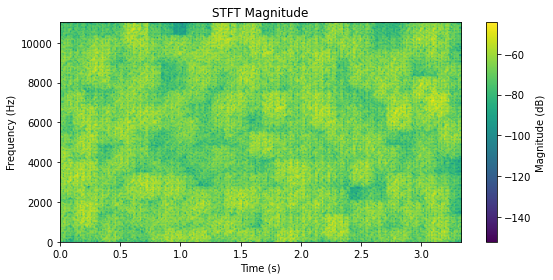

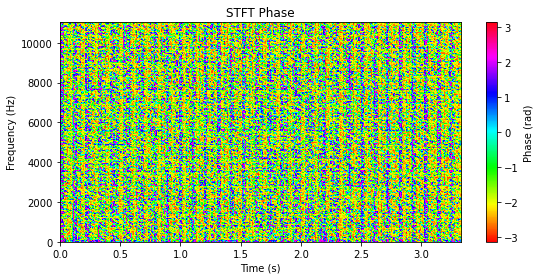

   📉 Reconstruction Error - Sample 5


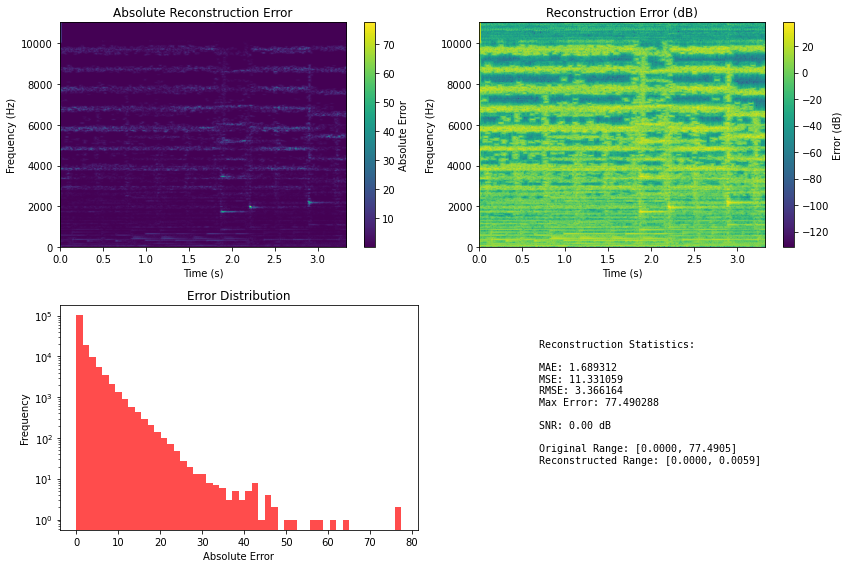

In [11]:
models_dict = {
    'style_encoder': style_encoder,
    'content_encoder': content_encoder,
    'decoder': decoder
}

train_loader = get_dataloader(
        piano_dir=config["piano_dir"],
        violin_dir=config["violin_dir"],
        batch_size=config["batch_size"],
        shuffle=True,
        stats_path=config["stats_path"]
    )

# Visualizza 3 campioni casuali
visualize_reconstruction(models_dict, train_loader, device, num_samples=5)
